# Problema de Negocio (Enunciado de Kaggle)

### Descripción

Lucas ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Lucas a mejorar ese modelo?

### Evaluación

Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión.

RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{d_i - f_i}{\sigma_i}\right)^2}$$

### Referencia

[Iván Cordero. (2024). Plan de negocio – DataTops®. Kaggle.](https://kaggle.com/competitions/datatops)


# Objetivo

En este Notebook realizaremos modificaciones en las columnas del dataset, eliminando y generando nuevas características que hagan las variables categóricas más descriptivas. Esto permitirá que los modelos de árboles sesguen mejor la información.

Posteriormente, prepararemos los datos para que sean aceptados para un modelo de CatBoost.


# 0. Librerías

In [1]:
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

# Añadir el path raíz "src"
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) 
if os.path.exists(root_path) and root_path not in sys.path: 
    sys.path.append(root_path)
    
from utils import datascience as ds
from utils import functions as fun
from utils import machinelearningtools as ml
from utils import vizdatatools as viz

# Establecer un estilo moderno con Seaborn
sns.set_theme(style="darkgrid", palette='bright')

# 1. Entendiendo el problema de negocio

El principal objetivo del proyecto es crear un modelo de Machine Learning que permita a Lucas:

- Establecer precios precisos: Determinar el precio de venta ideal para cada portátil, considerando sus características técnicas.
- El rendimiento del modelo será evaluado utilizando el Error Cuadrático Medio (RMSE).
- Contamos con dos sets de trabajo:
    - `train.csv`: set de *train* sobre el que evaluaré las métricas y con el que entrenaré el modelo.
    - `test.csv`: set de *test* con el que predecir los precios de los portátiles, cuyo resultado (*submission*) se cargará a Kaggle.


# 2. Obtener datos y un primer vistazo.

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv('../data/train.csv', index_col=0)
# df_train.index.name = None

df_train.head()

Company        Product   TypeName  Inches   ScreenResolution  \
laptop_ID                                                                
755            HP         250 G6   Notebook    15.6  Full HD 1920x1080   
618          Dell  Inspiron 7559     Gaming    15.6  Full HD 1920x1080   
909            HP    ProBook 450   Notebook    15.6  Full HD 1920x1080   
2           Apple    Macbook Air  Ultrabook    13.3           1440x900   
286          Dell  Inspiron 3567   Notebook    15.6  Full HD 1920x1080   

                                   Cpu   Ram               Memory  \
laptop_ID                                                           
755           Intel Core i3 6006U 2GHz   8GB            256GB SSD   
618        Intel Core i7 6700HQ 2.6GHz  16GB              1TB HDD   
909         Intel Core i7 7500U 2.7GHz   8GB              1TB HDD   
2                 Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
286         Intel Core i3 6006U 2.0GHz   4GB              1TB HDD   

                                      Gpu       OpSys  Weight  Price_in_euros  
laptop_ID                                                                      
755                 Intel HD Graphics 520  Windows 10  1.86kg          539.00  
618        Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg          879.01  
909                  Nvidia GeForce 930MX  Windows 10  2.04kg          900.00  
2                  Intel HD Graphics 6000       macOS  1.34kg          898.94  
286                    AMD Radeon R5 M430       Linux  2.25kg          428.00

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
for col in df_train.columns:
    print(col)
    display(df_train[col].unique())

Company


array(['HP', 'Dell', 'Apple', 'Lenovo', 'MSI', 'Toshiba', 'Acer', 'Chuwi',
       'Asus', 'Huawei', 'Razer', 'Mediacom', 'Google', 'Samsung',
       'Xiaomi', 'Microsoft', 'Vero', 'LG', 'Fujitsu'], dtype=object)

Product


array(['250 G6', 'Inspiron 7559', 'ProBook 450', 'Macbook Air',
       'Inspiron 3567', 'ProBook 650', 'Envy 13-AD007nv',
       'IdeaPad 320-15IKB', 'GL72M 7REX', 'Thinkpad T570', 'MacBook Pro',
       'Ideapad 320-15IKBR', 'IdeaPad 320-15IAP', 'Portege Z30-C-16P',
       'Latitude 5590', 'IdeaPad 110-15IBR', 'GP72MVR 7RFX',
       'ThinkPad X1', 'GL62 6QF', 'Portege X30-D-10X', 'Chromebook 11',
       'Inspiron 5567', 'IdeaPad 510s-14IKB', 'LapBook 15.6"',
       'GE62 Apache', 'ZBook 17', 'Inspiron 7567', 'VivoBook Pro',
       'Pro P2540UA-XO0198T', 'Thinkpad 13', 'MateBook X', 'Vostro 5568',
       '250 G5', 'EliteBook 840', 'Inspiron 7570', 'IdeaPad Y700-15ISK',
       'ThinkPad P51', 'IdeaPad 320-15IKBN', 'Portege Z30-C-1CV',
       'XPS 13', 'IdeaPad 510-15IKB',
       '15-bs002nv (i3-6006U/4GB/128GB/FHD/W10)', 'Blade Pro',
       'Rog Strix', 'ProBook 440', '15-AC110nv (i7-6500U/6GB/1TB/Radeon',
       'Probook 440', 'FX753VD-GC071T (i7-7700HQ/8GB/1TB/GeForce',
       'GS73VR 

TypeName


array(['Notebook', 'Gaming', 'Ultrabook', 'Workstation', 'Netbook',
       '2 in 1 Convertible'], dtype=object)

Inches


array([15.6, 13.3, 14. , 17.3, 11.6, 13. , 12. , 10.1, 12.5, 12.3, 15. ,
       14.1, 13.5, 11.3, 13.9, 15.4, 18.4])

ScreenResolution


array(['Full HD 1920x1080', '1440x900', '1366x768',
       'IPS Panel Full HD 1920x1080', 'IPS Panel 4K Ultra HD 3840x2160',
       'IPS Panel Retina Display 2560x1600', 'Touchscreen 1366x768',
       'IPS Panel Quad HD+ 2560x1440', 'IPS Panel 1366x768',
       'Full HD / Touchscreen 1920x1080', 'IPS Panel Full HD 2160x1440',
       'Quad HD+ 3200x1800', '4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'IPS Panel Touchscreen 1920x1200',
       'IPS Panel Touchscreen 2560x1440', 'Touchscreen 2400x1600',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2560x1440', 'Quad HD+ / Touchscreen 3200x1800',
       '4K Ultra HD 3840x2160',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800',
       'Touchscreen 2256x1504', '1600x900',
       'IPS Panel Touchscreen 1366x768',
       'Touchscreen / Quad HD+ 3200x1800', 'IPS Panel 2560x1440',
       'IPS Panel Quad HD+ 3200x

Cpu


array(['Intel Core i3 6006U 2GHz', 'Intel Core i7 6700HQ 2.6GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i3 6006U 2.0GHz', 'Intel Core i5 7300U 2.6GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7600U 2.8GHz',
       'Intel Core i5 2.9GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Celeron Quad Core N3710 1.6GHz',
       'Intel Celeron Dual Core N3060 1.6GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i5 8250U 1.6GHz',
       'AMD Ryzen 1700 3GHz', 'Intel Core i7 7820HK 2.9GHz',
       'Intel Core i5 1.3GHz', 'Intel Pentium Quad Core N3700 1.6GHz',
       'AMD A9-Series A9-9420 3GHz', 'Intel Core i7 7560U 2.4GHz',
       'Intel Core i

Ram


array(['8GB', '16GB', '4GB', '12GB', '32GB', '6GB', '2GB', '64GB', '24GB'],
      dtype=object)

Memory


array(['256GB SSD', '1TB HDD', '128GB Flash Storage',
       '128GB SSD +  1TB HDD', '512GB SSD', '500GB HDD',
       '256GB SSD +  256GB SSD', '128GB SSD', '32GB Flash Storage',
       '64GB Flash Storage', '1.0TB Hybrid', '2TB HDD',
       '256GB Flash Storage', '256GB SSD +  1TB HDD', '180GB SSD',
       '16GB Flash Storage', '1TB SSD', '256GB SSD +  2TB HDD',
       '32GB SSD', '1TB SSD +  1TB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  1TB HDD', '512GB SSD +  512GB SSD',
       '512GB SSD +  256GB SSD', '16GB SSD',
       '64GB Flash Storage +  1TB HDD', '64GB SSD', '128GB HDD',
       '240GB SSD', '512GB SSD +  2TB HDD', '508GB Hybrid', '8GB SSD',
       '256GB SSD +  500GB HDD', '1.0TB HDD', '512GB Flash Storage',
       '1TB HDD +  1TB HDD', '32GB HDD'], dtype=object)

Gpu


array(['Intel HD Graphics 520', 'Nvidia GeForce GTX 960<U+039C>',
       'Nvidia GeForce 930MX', 'Intel HD Graphics 6000',
       'AMD Radeon R5 M430', 'Intel HD Graphics 620',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050 Ti',
       'Intel Iris Graphics 550', 'Intel HD Graphics 505',
       'Intel UHD Graphics 620', 'Intel HD Graphics 405',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce GTX 960M',
       'Intel HD Graphics 400', 'AMD Radeon R7 M445',
       'AMD Radeon R7 M460', 'Intel HD Graphics', 'AMD FirePro W6150M',
       'Nvidia GeForce GTX 1050', 'Nvidia Quadro M1200',
       'AMD Radeon RX 580', 'Nvidia GeForce GTX 1080',
       'AMD Radeon R5 M330', 'Nvidia GeForce GTX 1070',
       'Intel HD Graphics 615', 'AMD Radeon 530', 'AMD Radeon 520',
       'Nvidia Quadro M620', 'Intel Iris Plus Graphics 640',
       'Nvidia Quadro M500M', 'Intel HD Graphics 510',
       'Intel Iris Plus Graphics 650', 'Nvidia GeForce 920MX ',
       'Intel HD Graphics 500', 'AMD Radeo

OpSys


array(['Windows 10', 'macOS', 'Linux', 'No OS', 'Chrome OS', 'Windows 7',
       'Android', 'Windows 10 S', 'Mac OS X'], dtype=object)

Weight


array(['1.86kg', '2.59kg', '2.04kg', '1.34kg', '2.25kg', '2.31kg',
       '1.32kg', '2.2kg', '2.7kg', '2.3kg', '1.37kg', '1.2kg', '1.88kg',
       '1.17kg', '1.05kg', '1.35kg', '1.5kg', '1.89kg', '2.4kg', '3.0kg',
       '2.65kg', '1.99kg', '2.37kg', '1.4kg', '2.36kg', '2.18kg',
       '1.96kg', '1.54kg', '3.14kg', '1.9kg', '1.13kg', '2.6kg', '2.67kg',
       '1.3kg', '1.91kg', '1.95kg', '3.25kg', '1.64kg', '1.44kg',
       '1.26kg', '3.49kg', '2.19kg', '1.63kg', '3kg', '2.43kg', '0.92kg',
       '2.1kg', '2.5kg', '1.48kg', '1.43kg', '2.06kg', '1.23kg', '1.8kg',
       '1.45kg', '1.93kg', '2.32kg', '0.69kg', '1.27kg', '1.25kg',
       '3.35kg', '2.56kg', '2.45kg', '1.47kg', '4.5kg', '2.0kg', '1.36kg',
       '1.1kg', '1.71kg', '1.21kg', '1.7kg', '1.94kg', '1.14kg', '1.6kg',
       '1.29kg', '2.05kg', '1.49kg', '4.36kg', '2.62kg', '2.21kg',
       '1.84kg', '2.17kg', '1.16kg', '2kg', '2.29kg', '2.9kg', '2.8kg',
       '1.65kg', '3.78kg', '2.73kg', '1.252kg', '0.98kg', '2.20kg',
       '

Price_in_euros


array([ 539.  ,  879.01,  900.  ,  898.94,  428.  , 1124.  ,  699.  ,
        499.  , 1348.48, 2445.  , 1958.9 ,  609.  ,  344.  , 1747.  ,
       1298.  ,  329.  , 1409.  , 1686.64, 1169.  , 1285.  ,  355.  ,
        859.01,  799.  ,  244.99, 1229.  , 2899.  ,  949.  , 1350.  ,
        398.99, 1010.  , 1349.  ,  557.37,  836.  ,  500.  , 1000.  ,
       1907.99,  299.  , 1049.  , 1875.  , 1272.  , 1925.  ,  597.  ,
       1195.  , 1268.  ,  709.  ,  485.  ,  439.  , 2199.  , 1049.26,
        735.  ,  295.  , 6099.  ,  764.  , 1084.  , 1187.  , 2449.  ,
        444.  ,  324.  , 1510.  ,  745.  , 1799.  ,  393.49, 1292.  ,
       1189.  , 1513.  ,  650.  , 1763.  , 1379.  , 2050.38,  375.  ,
       1962.99, 1426.66,  589.52, 1072.  ,  549.  , 2040.  , 2339.  ,
        459.  ,  349.  ,  819.  , 1185.43, 1249.26,  255.  ,  465.  ,
        980.  , 1579.  ,  479.  , 1713.49, 2349.  , 1207.  , 1584.  ,
       1049.6 ,  589.  , 1495.  , 1144.5 , 1949.  , 1943.  , 1096.  ,
        229.  , 1149

Tenía la esperanza de poder encontrar en "ScreenResolution" y/o en "Memory" clases que tuvieran la misma información y que se pudieran agrupar, pero parece que están bastante bien escogidas todas las columna categóricas y no hay redundancias. 

Sin embargo en este Notebook sí vamos a desglosar un poco más las features.

In [5]:
ds.get_cardinality(df_train, threshold_categorical=38, threshold_continuous=30.0)

pandas.DataFrame shape: (912, 12)


Card     %_Card NaN_Values %_NaN_Values     Type  \
Company            19   2.083333          0          0.0   object   
Product           480  52.631579          0          0.0   object   
TypeName            6   0.657895          0          0.0   object   
Inches             17   1.864035          0          0.0  float64   
ScreenResolution   36   3.947368          0          0.0   object   
Cpu               107  11.732456          0          0.0   object   
Ram                 9   0.986842          0          0.0   object   
Memory             37   4.057018          0          0.0   object   
Gpu                93  10.197368          0          0.0   object   
OpSys               9   0.986842          0          0.0   object   
Weight            165  18.092105          0          0.0   object   
Price_in_euros    603  66.118421          0          0.0  float64   

                                 Class  
Company                      Categoric  
Product           Numeric - Continuous  
TypeName                     Categoric  
Inches                       Categoric  
ScreenResolution             Categoric  
Cpu                 Numeric - Discrete  
Ram                          Categoric  
Memory                       Categoric  
Gpu                 Numeric - Discrete  
OpSys                        Categoric  
Weight              Numeric - Discrete  
Price_in_euros    Numeric - Continuous

Conclusiones

- Estoy bastante de acuerdo con la tabla anterior en la propuestas de clases (entre categóricas y numéricas). Voy a considerar como categóricas aqullas features que tengan una cardinalidad porcentual inferior al 5%. Además voy a intentar beneficiarme de que es un dataset compuesto de demasiadas columnas "object".

- Es bueno ver que no hay valores missing.

- Es un claro problema de regresión. El *target* es "Price_in_euros", aunque más adelante haremos una transformación sobre el target para que tenga una distribución normal.

En esta ocasión sin embargo voy a segmentar un poco más las features categóricas, porque he visto que con expresiones regulares u otras técnicas puedo sacar más información de ellas.

## 2.1 Tranformaciones directamente sobre el set

`NOTA`: ¡¡Esto no es lo habitual!! Habría que hacer esto después del split de train y validation, pero como ya vengo trabajando el dataframe de train y voy a aplicar las mismas transformaciones en los dos sets lo voy a hacer directamente sobre el dataframe original (en realidad voy a hacer una copia) para ahorrar tiempo.


Para hacer tranformaciones más potentes sobre las features voy a hacer una copia de seguridad.

In [6]:
# Back-up para hacer modificaiones
df_train_enhanced = df_train.copy()

### Ram y Weight

Voy a transfor a numérica la columa de "Weight" (limpiando su string del caracter "kg") porque todas las demás las voy a usar como categóricas. 

En la feature "Ram" elimino la cadena "GB" para que los modelos que no admiten categóricas puedan trabajar sin problema.

In [7]:
# Transformar la columna "Weight" a numéricas, y convertir "Inches" en categórica
df_train_enhanced['Ram_GB'] = df_train_enhanced['Ram'].str.replace('GB', '').astype(int)
df_train_enhanced["Weight_Kg"] = df_train_enhanced['Weight'].str.replace('kg', '').astype(float)
df_train_enhanced.drop(['Ram', 'Weight'], axis=1, inplace=True)

### Product

Product es una feaure con un a cardinalidad tan alta y tan poco descriptiva que directamente me la voy a cargar.


In [8]:
df_train_enhanced.drop(columns=['Product'], inplace=True)

### Memory

La "Memory" se puede desglosar el tipo de almacenamiento (HDD, SSD, Flash Memory e Hybrid) y capacidad (GB), de esta forma podremos darle una categoría ordinal a estas features, porque por lo general más espacio significa mayor precio.

In [9]:
# Aplicar la función a la columna del DataFrame
df_train_enhanced[['HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = df_train_enhanced['Memory'].apply(fun.extract_memory_by_type)

# Aplicar la función a la columna 'Memory' del DataFrame
# df_train_enhanced = df_train_enhanced.join(df_train_enhanced['Memory'].apply(fun.extract_memory_features))


In [10]:
# Agrupar por la columna original 'Memory' y comprobar que el algoritmo ha funcionado bien
display(df_train_enhanced.groupby('Memory')[['HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB']].first())


HDD_GB  SSD_GB  Flash_Storage_GB  Hybrid_GB
Memory                                                                    
1.0TB HDD                        1000       0                 0          0
1.0TB Hybrid                        0       0                 0       1000
128GB Flash Storage                 0       0               128          0
128GB HDD                         128       0                 0          0
128GB SSD                           0     128                 0          0
128GB SSD +  1TB HDD             1000     128                 0          0
128GB SSD +  2TB HDD             2000     128                 0          0
16GB Flash Storage                  0       0                16          0
16GB SSD                            0      16                 0          0
180GB SSD                           0     180                 0          0
1TB HDD                          1000       0                 0          0
1TB HDD +  1TB HDD               2000       0                 0          0
1TB SSD                             0    1000                 0          0
1TB SSD +  1TB HDD               1000    1000                 0          0
240GB SSD                           0     240                 0          0
256GB Flash Storage                 0       0               256          0
256GB SSD                           0     256                 0          0
256GB SSD +  1TB HDD             1000     256                 0          0
256GB SSD +  256GB SSD              0     512                 0          0
256GB SSD +  2TB HDD             2000     256                 0          0
256GB SSD +  500GB HDD            500     256                 0          0
2TB HDD                          2000       0                 0          0
32GB Flash Storage                  0       0                32          0
32GB HDD                           32       0                 0          0
32GB SSD                            0      32                 0          0
500GB HDD                         500       0                 0          0
508GB Hybrid                        0       0                 0        508
512GB Flash Storage                 0       0               512          0
512GB SSD                           0     512                 0          0
512GB SSD +  1TB HDD             1000     512                 0          0
512GB SSD +  256GB SSD              0     768                 0          0
512GB SSD +  2TB HDD             2000     512                 0          0
512GB SSD +  512GB SSD              0    1024                 0          0
64GB Flash Storage                  0       0                64          0
64GB Flash Storage +  1TB HDD    1000       0                64          0
64GB SSD                            0      64                 0          0
8GB SSD                             0       8                 0          0

In [11]:
# Eliminar "Memory"
df_train_enhanced.drop(columns=['Memory'], inplace=True)

### ScreenResolution 

Esta columna se puede desglosar en nuevas características que representen la resolución, el tipo de panel y la presencia de la función táctil (touchscreen). De esta forma tenemos dos columas que son categóricas ordinales ('Screen_Width' y 'Screen_Height'), y otrasa que son binarias ('Is_IPS', 'Is_Retina' e 'Is_Touchscreen'), lo cual va a venir bien a los modelos también.

In [12]:
# Aplicar la función al DataFrame
df_train_enhanced[['Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen']] = df_train_enhanced['ScreenResolution'].apply(fun.extract_screen_features)


In [13]:
# Agrupar por la columna original 'ScreenResolution' y comprobar que el algoritmo ha funcionado bien
display(df_train_enhanced.groupby('ScreenResolution')[['Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen']].first())

Screen_Width  Screen_Height  \
ScreenResolution                                                             
1366x768                                               1366            768   
1440x900                                               1440            900   
1600x900                                               1600            900   
1920x1080                                              1920           1080   
2560x1440                                              2560           1440   
4K Ultra HD / Touchscreen 3840x2160                    3840           2160   
4K Ultra HD 3840x2160                                  3840           2160   
Full HD / Touchscreen 1920x1080                        1920           1080   
Full HD 1920x1080                                      1920           1080   
IPS Panel 1366x768                                     1366            768   
IPS Panel 2560x1440                                    2560           1440   
IPS Panel 4K Ultra HD / Touchscreen 3840x2160          3840           2160   
IPS Panel 4K Ultra HD 3840x2160                        3840           2160   
IPS Panel Full HD / Touchscreen 1920x1080              1920           1080   
IPS Panel Full HD 1920x1080                            1920           1080   
IPS Panel Full HD 1920x1200                            1920           1200   
IPS Panel Full HD 2160x1440                            2160           1440   
IPS Panel Full HD 2560x1440                            2560           1440   
IPS Panel Quad HD+ / Touchscreen 3200x1800             3200           1800   
IPS Panel Quad HD+ 2560x1440                           2560           1440   
IPS Panel Quad HD+ 3200x1800                           3200           1800   
IPS Panel Retina Display 2304x1440                     2304           1440   
IPS Panel Retina Display 2560x1600                     2560           1600   
IPS Panel Retina Display 2880x1800                     2880           1800   
IPS Panel Touchscreen 1366x768                         1366            768   
IPS Panel Touchscreen 1920x1200                        1920           1200   
IPS Panel Touchscreen 2560x1440                        2560           1440   
Quad HD+ / Touchscreen 3200x1800                       3200           1800   
Quad HD+ 3200x1800                                     3200           1800   
Touchscreen / 4K Ultra HD 3840x2160                    3840           2160   
Touchscreen / Full HD 1920x1080                        1920           1080   
Touchscreen / Quad HD+ 3200x1800                       3200           1800   
Touchscreen 1366x768                                   1366            768   
Touchscreen 2256x1504                                  2256           1504   
Touchscreen 2400x1600                                  2400           1600   
Touchscreen 2560x1440                                  2560           1440   

                                               Is_IPS  Is_Retina  \
ScreenResolution                                                   
1366x768                                            0          0   
1440x900                                            0          0   
1600x900                                            0          0   
1920x1080                                           0          0   
2560x1440                                           0          0   
4K Ultra HD / Touchscreen 3840x2160                 0          0   
4K Ultra HD 3840x2160                               0          0   
Full HD / Touchscreen 1920x1080                     0          0   
Full HD 1920x1080                                   0          0   
IPS Panel 1366x768                                  1          0   
IPS Panel 2560x1440                                 1          0   
IPS Panel 4K Ultra HD / Touchscreen 3840x2160       1          0   
IPS Panel 4K Ultra HD 3840x2160                     1          0   
IPS Panel Full HD / Touchscreen 1920x1080           1         

In [14]:
# Eliminar "ScreenResolution"
df_train_enhanced.drop(columns=['ScreenResolution'], inplace=True)

### CPU 

Es bastante sencillo extraer su información porque la primera palabra es la marca, la ulima los GHz,  la penultima el modelo, y todo lo del medio es la serie. 

Voy a aplicar directamente una columna que valga 1 si es AMD (porque hay menos y quiero que aprenda de ellos), y 0 si es Intel

In [15]:
# Aplicando la función a la columna del DataFrame
df_train_enhanced[['Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz']] = df_train_enhanced['Cpu'].apply(fun.extract_cpu_features)


In [16]:
pd.set_option('display.max_rows', None)

# Agrupar por la columna original 'ScreenResolution' y comprobar que el algoritmo ha funcionado bien
display(df_train_enhanced.groupby('Cpu')[['Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz']].first())


Cpu_isAMD         Cpu_Series  Cpu_Model  \
Cpu                                                                             
AMD A10-Series 9600P 2.4GHz                   1         A10-Series      9600P   
AMD A10-Series 9620P 2.5GHz                   1         A10-Series      9620P   
AMD A10-Series A10-9620P 2.5GHz               1         A10-Series  A10-9620P   
AMD A12-Series 9720P 2.7GHz                   1         A12-Series      9720P   
AMD A12-Series 9720P 3.6GHz                   1         A12-Series      9720P   
AMD A6-Series 7310 2GHz                       1          A6-Series       7310   
AMD A6-Series 9220 2.5GHz                     1          A6-Series       9220   
AMD A6-Series 9220 2.9GHz                     1          A6-Series       9220   
AMD A6-Series A6-9220 2.5GHz                  1          A6-Series    A6-9220   
AMD A8-Series 7410 2.2GHz                     1          A8-Series       7410   
AMD A9-Series 9410 2.9GHz                     1          A9-Series       9410   
AMD A9-Series 9420 2.9GHz                     1          A9-Series       9420   
AMD A9-Series 9420 3GHz                       1          A9-Series       9420   
AMD A9-Series A9-9420 3GHz                    1          A9-Series    A9-9420   
AMD E-Series 6110 1.5GHz                      1           E-Series       6110   
AMD E-Series 7110 1.8GHz                      1           E-Series       7110   
AMD E-Series 9000e 1.5GHz                     1           E-Series      9000e   
AMD E-Series E2-6110 1.5GHz                   1           E-Series    E2-6110   
AMD E-Series E2-9000 2.2GHz                   1           E-Series    E2-9000   
AMD E-Series E2-9000e 1.5GHz                  1           E-Series   E2-9000e   
AMD FX 9830P 3GHz                             1                 FX      9830P   
AMD Ryzen 1600 3.2GHz                         1              Ryzen       1600   
AMD Ryzen 1700 3GHz                           1              Ryzen       1700   
Intel Atom X5-Z8350 1.44GHz                   0               Atom   X5-Z8350   
Intel Atom Z8350 1.92GHz                      0               Atom      Z8350   
Intel Atom x5-Z8300 1.44GHz                   0               Atom   x5-Z8300   
Intel Atom x5-Z8350 1.44GHz                   0               Atom   x5-Z8350   
Intel Atom x5-Z8550 1.44GHz                   0               Atom   x5-Z8550   
Intel Celeron Dual Core 3205U 1.5GHz          0  Celeron Dual Core      3205U   
Intel Celeron Dual Core 3855U 1.6GHz          0  Celeron Dual Core      3855U   
Intel Celeron Dual Core N3050 1.6GHz          0  Celeron Dual Core      N3050   
Intel Celeron Dual Core N3060 1.6GHz          0  Celeron Dual Core      N3060   
Intel Celeron Dual Core N3350 1.1GHz          0  Celeron Dual Core      N3350   
Intel Celeron Dual Core N3350 2.0GHz          0  Celeron Dual Core      N3350   
Intel Celeron Dual Core N3350 2GHz            0  Celeron Dual Core      N3350   
Intel Celeron Quad Core N3160 1.6GHz          0  Celeron Quad Core      N3160   
Intel Celeron Quad Core N3450 1.1GHz          0  Celeron Quad Core      N3450   
Intel Celeron Quad Core N3710 1.6GHz          0  Celeron Quad Core      N3710   
Intel Core M 1.1GHz                           0               Core          M   
Intel Core M 1.2GHz                           0               Core          M   
Intel Core M 6Y30 0.9GHz                      0             Core M       6Y30   
Intel Core M 6Y54 1.1GHz                      0             Core M       6Y54   
Intel Core M 6Y75 1.2GHz                      0             Core M       6Y75   
Intel Core M 7Y30 1.0GHz                      0             Core M       7Y30   
Intel Core M M3-6Y30 0.9GHz                   0             Core M    M3-6Y30   
Intel Core M M7-6Y75 1.2GHz                   0             Core M    M7-6Y75   
Intel Core M m3 1.2GHz                        0             Core M         m3   
Intel Core M m3-7Y30 2.2GHz                   0             Core M   

In [17]:
# Eliminar "Cpu"
df_train_enhanced.drop(columns=['Cpu'], inplace=True)

### GPU

La información de GPU es más complicada de extraer. Por el momento voy a hacer un modelo simple para saber la marca y el modelo.

In [18]:
# Aplicando la función a la columna del DataFrame
df_train_enhanced[['Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']] = df_train_enhanced['Gpu'].apply(fun.extract_gpu_features)

In [19]:
# Agrupar por la columna original 'ScreenResolution' y comprobar que el algoritmo ha funcionado bien
display(df_train_enhanced.groupby('Gpu')[['Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']].first())

Gpu_isAMD  Gpu_isIntel  \
Gpu                                                      
AMD FirePro W4190M                      1            0   
AMD FirePro W4190M                      1            0   
AMD FirePro W5130M                      1            0   
AMD FirePro W6150M                      1            0   
AMD R17M-M1-70                          1            0   
AMD R4 Graphics                         1            0   
AMD Radeon 520                          1            0   
AMD Radeon 530                          1            0   
AMD Radeon 540                          1            0   
AMD Radeon Pro 455                      1            0   
AMD Radeon Pro 555                      1            0   
AMD Radeon R2                           1            0   
AMD Radeon R2 Graphics                  1            0   
AMD Radeon R4                           1            0   
AMD Radeon R4 Graphics                  1            0   
AMD Radeon R5                           1            0   
AMD Radeon R5 430                       1            0   
AMD Radeon R5 520                       1            0   
AMD Radeon R5 M315                      1            0   
AMD Radeon R5 M330                      1            0   
AMD Radeon R5 M420                      1            0   
AMD Radeon R5 M420X                     1            0   
AMD Radeon R5 M430                      1            0   
AMD Radeon R7                           1            0   
AMD Radeon R7 M365X                     1            0   
AMD Radeon R7 M440                      1            0   
AMD Radeon R7 M445                      1            0   
AMD Radeon R7 M460                      1            0   
AMD Radeon RX 540                       1            0   
AMD Radeon RX 550                       1            0   
AMD Radeon RX 560                       1            0   
AMD Radeon RX 580                       1            0   
Intel Graphics 620                      0            1   
Intel HD Graphics                       0            1   
Intel HD Graphics 400                   0            1   
Intel HD Graphics 405                   0            1   
Intel HD Graphics 500                   0            1   
Intel HD Graphics 505                   0            1   
Intel HD Graphics 510                   0            1   
Intel HD Graphics 515                   0            1   
Intel HD Graphics 520                   0            1   
Intel HD Graphics 5300                  0            1   
Intel HD Graphics 540                   0            1   
Intel HD Graphics 6000                  0            1   
Intel HD Graphics 615                   0            1   
Intel HD Graphics 620                   0            1   
Intel HD Graphics 620                   0            1   
Intel HD Graphics 630                   0            1   
Intel Iris Graphics 540                 0            1   
Intel Iris Graphics 550                 0            1   
Intel Iris Plus Graphics 640            0            1   
Intel Iris Plus Graphics 650            0            1   
Intel Iris Pro Graphics                 0            1   
Intel UHD Graphics 620                  0            1   
Nvidia GTX 980 SLI                      0            0   
Nvidia GeForce 150MX                    0            0   
Nvidia GeForce 920M                     0            0   
Nvidia GeForce 920MX                    0            0   
Nvidia GeForce 920MX                    0            0   
Nvidia GeForce 930M                     0            0   
Nvidia GeForce 930MX                    0            0   
Nvidia GeForce 930MX                    0            0   
Nvidia GeForce 940MX                    0            0   
Nvidia GeForce GT 940MX                 0            0   
Nvidia GeForce GTX 1050                 0            0   
Nvidia GeForce GTX 1050 Ti              0            0   
Nvidia GeForce GTX 1050M                0            0   
Nvidia GeForce GTX 1050Ti     

In [20]:
# Eliminar "Gpu"
df_train_enhanced.drop(columns=['Gpu'], inplace=True)

### Transformar las variables categóricas a enteros o string para que lo pueda trabajar Catboost


In [21]:
df_train_enhanced[['Inches', 'Cpu_GHz']] = df_train_enhanced[['Inches', 'Cpu_GHz']].astype(str)


### Cardinalidades nuevas

In [22]:
ds.get_cardinality(df_train_enhanced, threshold_categorical=26)

pandas.DataFrame shape: (912, 23)


Card     %_Card NaN_Values %_NaN_Values     Type  \
Company            19   2.083333          0          0.0   object   
TypeName            6   0.657895          0          0.0   object   
Inches             17   1.864035          0          0.0   object   
OpSys               9   0.986842          0          0.0   object   
Price_in_euros    603  66.118421          0          0.0  float64   
Ram_GB              9   0.986842          0          0.0    int32   
Weight_Kg         158  17.324561          0          0.0  float64   
HDD_GB              6   0.657895          0          0.0    int64   
SSD_GB             13   1.425439          0          0.0    int64   
Flash_Storage_GB    7   0.767544          0          0.0    int64   
Hybrid_GB           3   0.328947          0          0.0    int64   
Screen_Width       12   1.315789          0          0.0    int64   
Screen_Height       9   0.986842          0          0.0    int64   
Is_IPS              2   0.219298          0          0.0    int64   
Is_Retina           2   0.219298          0          0.0    int64   
Is_Touchscreen      2   0.219298          0          0.0    int64   
Cpu_isAMD           2   0.219298          0          0.0    int64   
Cpu_Series         20   2.192982          0          0.0   object   
Cpu_Model          84   9.210526          0          0.0   object   
Cpu_GHz            25   2.741228          0          0.0   object   
Gpu_isAMD           2   0.219298          0          0.0    int64   
Gpu_isIntel         2   0.219298          0          0.0    int64   
Gpu_Model          89   9.758772          0          0.0   object   

                                 Class  
Company                      Categoric  
TypeName                     Categoric  
Inches                       Categoric  
OpSys                        Categoric  
Price_in_euros    Numeric - Continuous  
Ram_GB                       Categoric  
Weight_Kg           Numeric - Discrete  
HDD_GB                       Categoric  
SSD_GB                       Categoric  
Flash_Storage_GB             Categoric  
Hybrid_GB                    Categoric  
Screen_Width                 Categoric  
Screen_Height                Categoric  
Is_IPS                          Binary  
Is_Retina                       Binary  
Is_Touchscreen                  Binary  
Cpu_isAMD                       Binary  
Cpu_Series                   Categoric  
Cpu_Model           Numeric - Discrete  
Cpu_GHz                      Categoric  
Gpu_isAMD                       Binary  
Gpu_isIntel                     Binary  
Gpu_Model           Numeric - Discrete

In [23]:
df_train_enhanced.shape

(912, 23)

# 3. Split de train y validation

Hago esta separación desde el principio para no contaminar los datos

In [24]:
# Train-Test Split.
train_set, valid_set = train_test_split(df_train_enhanced, test_size=0.2)

target = "Price_in_euros"

print(train_set.shape)
print(valid_set.shape)

(729, 23)
(183, 23)


# 4. Mini-EDA

## 4.1 Transformaciones

Ya he hecho antes las transformaciones por comodidad en el dataframe original

In [25]:
# Quitar el límite de columnas
pd.set_option('display.max_columns', None)

display(train_set.describe(include='all'))


Company  TypeName Inches       OpSys  Price_in_euros      Ram_GB  \
count      729       729    729         729      729.000000  729.000000   
unique      19         6     16           9             NaN         NaN   
top         HP  Notebook   15.6  Windows 10             NaN         NaN   
freq       156       405    359         594             NaN         NaN   
mean       NaN       NaN    NaN         NaN     1115.665322    8.268861   
std        NaN       NaN    NaN         NaN      699.413257    5.236613   
min        NaN       NaN    NaN         NaN      174.000000    2.000000   
25%        NaN       NaN    NaN         NaN      598.000000    4.000000   
50%        NaN       NaN    NaN         NaN      979.000000    8.000000   
75%        NaN       NaN    NaN         NaN     1495.000000    8.000000   
max        NaN       NaN    NaN         NaN     6099.000000   64.000000   

         Weight_Kg       HDD_GB       SSD_GB  Flash_Storage_GB    Hybrid_GB  \
count   729.000000   729.000000   729.000000        729.000000   729.000000   
unique         NaN          NaN          NaN               NaN          NaN   
top            NaN          NaN          NaN               NaN          NaN   
freq           NaN          NaN          NaN               NaN          NaN   
mean      2.017853   402.825789   181.585734          5.706447     4.115226   
std       0.672150   501.335561   194.812529         33.161716    64.061851   
min       0.690000     0.000000     0.000000          0.000000     0.000000   
25%       1.480000     0.000000     0.000000          0.000000     0.000000   
50%       2.040000     0.000000   128.000000          0.000000     0.000000   
75%       2.300000  1000.000000   256.000000          0.000000     0.000000   
max       4.700000  2000.000000  1024.000000        512.000000  1000.000000   

        Screen_Width  Screen_Height      Is_IPS   Is_Retina  Is_Touchscreen  \
count     729.000000     729.000000  729.000000  729.000000      729.000000   
unique           NaN            NaN         NaN         NaN             NaN   
top              NaN            NaN         NaN         NaN             NaN   
freq             NaN            NaN         NaN         NaN             NaN   
mean     1885.130316    1065.563786    0.272977    0.013717        0.148148   
std       501.372102     287.901982    0.445795    0.116395        0.355491   
min      1366.000000     768.000000    0.000000    0.000000        0.000000   
25%      1366.000000     768.000000    0.000000    0.000000        0.000000   
50%      1920.000000    1080.000000    0.000000    0.000000        0.000000   
75%      1920.000000    1080.000000    1.000000    0.000000        0.000000   
max      3840.000000    2160.000000    1.000000    1.000000        1.000000   

         Cpu_isAMD Cpu_Series Cpu_Model Cpu_GHz   Gpu_isAMD  Gpu_isIntel  \
count   729.000000        729       729     729  729.000000   729.000000   
unique         NaN         19        77      24         NaN          NaN   
top            NaN    Core i7     7200U     2.5         NaN          NaN   
freq           NaN        292       106     169         NaN          NaN   
mean      0.041152        NaN       NaN     NaN    0.116598     0.570645   
std       0.198779        NaN       NaN     NaN    0.321161     0.495324   
min       0.000000        NaN       NaN     NaN    0.000000     0.000000   
25%       0.000000        NaN       NaN     NaN    0.000000     0.000000   
50%       0.000000        NaN       NaN     NaN    0.000000     1.000000   
75%       0.000000        NaN       NaN     NaN    0.000000     1.000000   
max       1.000000        NaN       NaN     NaN    1.000000     1.000000   

              Gpu_Model  
count               729  
unique               82  
top     HD Graphics 620  
freq                149  
mean                NaN  
std                 NaN  
min                 NaN  
25%                 NaN  
50%                 NaN  
75%                 NaN  
max      

## 4.2 Distribución del target

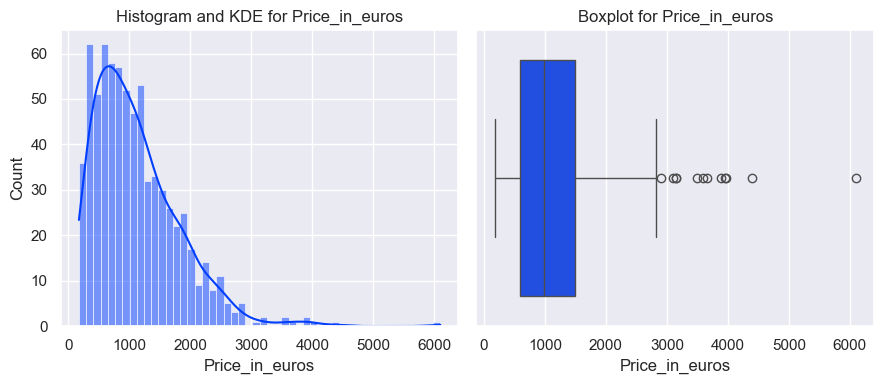

In [26]:
# Crear figura y subgráficas
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Graficar el histograma con KDE en la primera subgráfica
sns.histplot(train_set[target], kde=True, bins=50, ax=axs[0])
axs[0].set_title(f'Histogram and KDE for {target}')
axs[0].set_xlabel(target)

# Graficar el boxplot horizontal en la segunda subgráfica
sns.boxplot(x=train_set[target], ax=axs[1], orient='h')
axs[1].set_title(f'Boxplot for {target}')
axs[1].set_xlabel(target)

# Ajustar el layout
plt.tight_layout()
plt.show()


Hay varios valores outliers por arriba, que si los dejo en el modelo puede que modifiquen la métrica que estoy buscando. ~~Los voy a eliminar a riesgo de no aprender nada de los ordenadores más caros del set.~~ 

En esta ocasión NO los voy a eliminar.

NOTA: He encontrado que esto se podría resolver a posteriori con `RobustScaler()`.

In [27]:
# Calcular los cuartiles y el IQR
Q1 = train_set[target].quantile(0.25)
Q3 = train_set[target].quantile(0.75)
IQR = Q3 - Q1

# Definir límite superior
upper_bound = Q3 + 1.5 * IQR
print('Precio límite de los outliers:', upper_bound, '€.')

Precio límite de los outliers: 2840.5 €.


En general, para modelos como CatBoost y LightGBM, no es necesario transformar el target numérico aunque no siga una distribución gaussiana.

Sin embargo, vamos a considerar transformar el target porque:
- El target tiene valores extremo y un rango muy amplio.
- Para el RMSE, reducir la escala del target puede evitar que valores grandes dominen la métrica de evaluación.

A continuación muestro dos transformaciones no lineales que se pueden emplear en el target (como son la logaritmica y la raíz cuadrada).

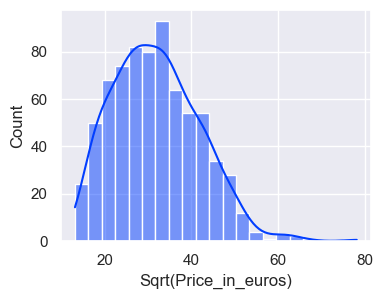

In [28]:
# Transformación raíz cuadrada.
plt.figure(figsize=(4, 3))
sns.histplot(np.sqrt(train_set[target]), kde=True)
plt.xlabel('Sqrt(' + target + ')', fontsize=12)  
plt.show()

En esta ocasión prefiero aplicar una `tranformación logarítmica al target`, a ver si de esta forma mejoro los resultados de las estimaciones. Pero cuidado, porque después habrá que hacer la des-transformación.

`Box-Cox` y `Yeo-Johnson` a través de Power Transform probablemente sean más convenientes, pero de momento los dejo fuera de mi análisis por tiempo. Además de momento voy a apostar por algoritmos de boosting en el que las distancias y distribución tienen menor importancia.

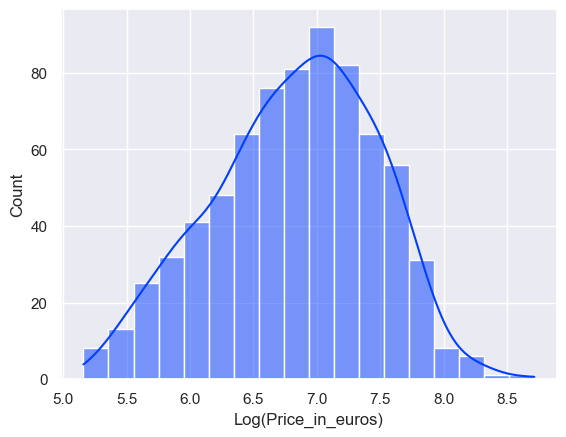

In [29]:
# Transformación logarítmica
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])
valid_set['log_price_euros'] = np.log(valid_set['Price_in_euros'])

# Eliminar el target original
# train_set.drop(['Price_in_euros'], axis=1, inplace=True)
# valid_set.drop(['Price_in_euros'], axis=1, inplace=True)

sns.histplot(train_set['log_price_euros'], kde=True)
plt.xlabel('Log(' + target + ')', fontsize=12)  
plt.show()

### Análisis de la única variable numérica.

Parece que tiene una distribución conveniente para los modelos, así que no voy a aplicar el logaritmo, pero después sí estandarizaré.

<Axes: xlabel='Weight_Kg', ylabel='Count'>

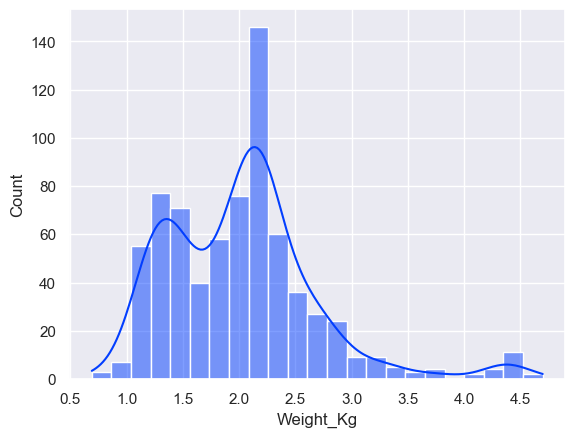

In [30]:
sns.histplot(train_set['Weight_Kg'], kde=True)

## 4.3 Análisis bivariante

Voy a inspeccionar visualmente aquellas variables en las que se pueda ver algo.

Definamos primero las variables categóricas de las numéricas.

In [31]:
# Definir variables numéricas, categóricas y categóricas con alta cardinalidad
target = 'log_price_euros'
num_features = ['Weight_Kg']
cat_features_high_card = ['Cpu_Model', 'Gpu_Model']
cat_features = [col for col in train_set.columns.to_list() if col not in (num_features + [target] + ['Price_in_euros'])]

print(target)
print(num_features)
print(cat_features_high_card)
print(cat_features)


log_price_euros
['Weight_Kg']
['Cpu_Model', 'Gpu_Model']
['Company', 'TypeName', 'Inches', 'OpSys', 'Ram_GB', 'HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB', 'Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen', 'Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz', 'Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']


#### Inspección de las variables categóricas.


In [32]:
# Variable para almacenar el máximo número de valores únicos
cat_max_nunique = 0  

for feature in [feat for feat in cat_features if feat not in cat_features_high_card]:
    unique_values = train_set[feature].nunique()
    print(f'{feature}: {unique_values} valores únicos')
        
    # Actualizar el valor máximo si el actual es mayor
    if unique_values > cat_max_nunique:
        cat_max_nunique = unique_values

print(f'El número más alto de valores únicos es: {cat_max_nunique}')


Company: 19 valores únicos
TypeName: 6 valores únicos
Inches: 16 valores únicos
OpSys: 9 valores únicos
Ram_GB: 8 valores únicos
HDD_GB: 6 valores únicos
SSD_GB: 13 valores únicos
Flash_Storage_GB: 7 valores únicos
Hybrid_GB: 2 valores únicos
Screen_Width: 12 valores únicos
Screen_Height: 9 valores únicos
Is_IPS: 2 valores únicos
Is_Retina: 2 valores únicos
Is_Touchscreen: 2 valores únicos
Cpu_isAMD: 2 valores únicos
Cpu_Series: 19 valores únicos
Cpu_GHz: 24 valores únicos
Gpu_isAMD: 2 valores únicos
Gpu_isIntel: 2 valores únicos
El número más alto de valores únicos es: 24


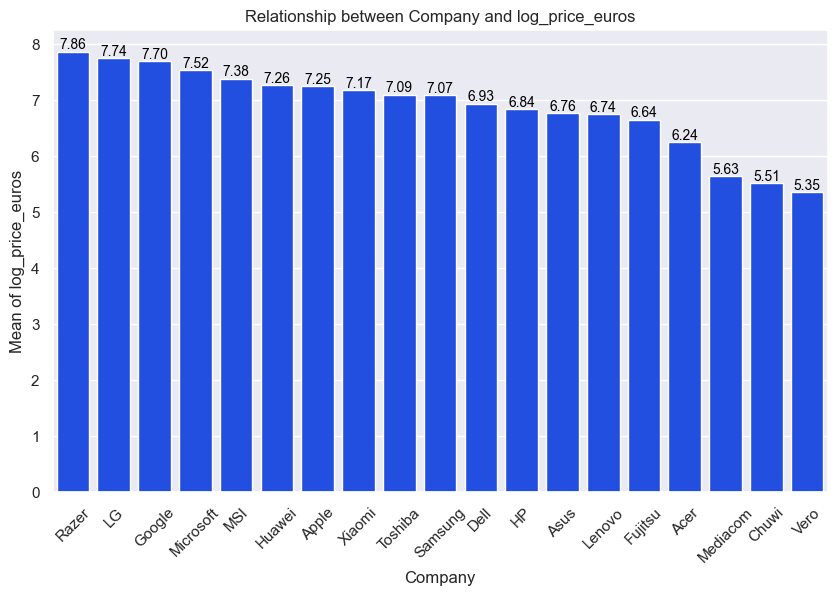

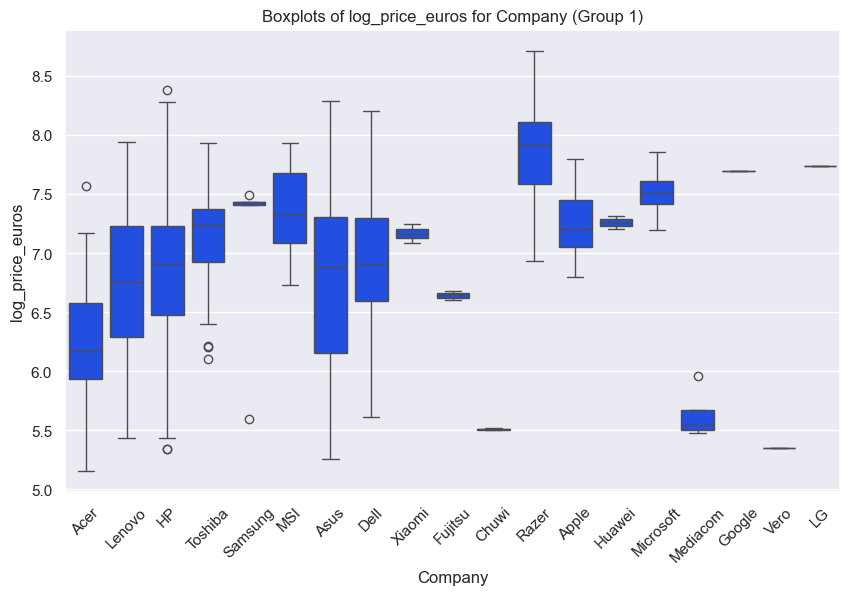

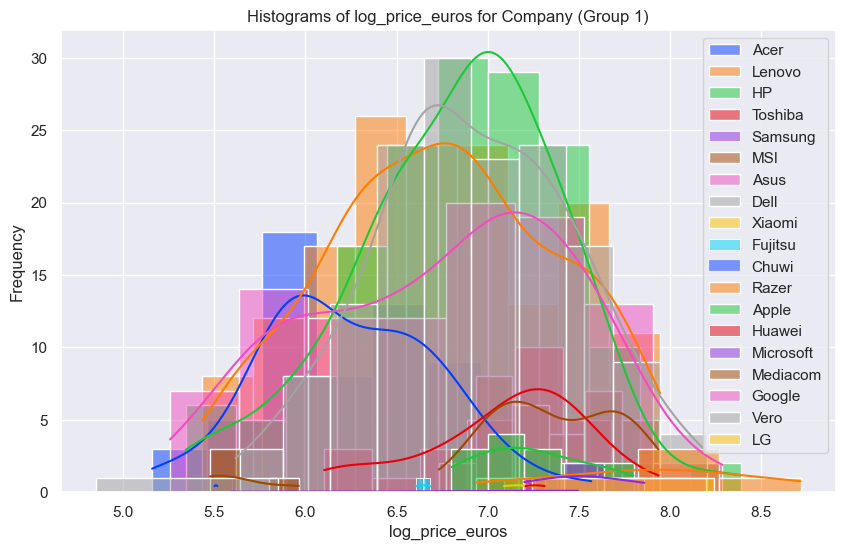

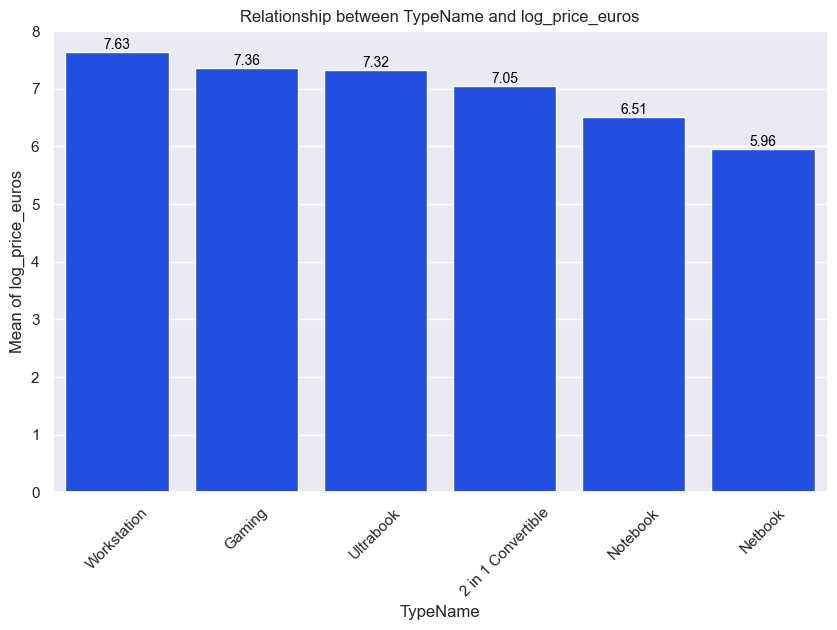

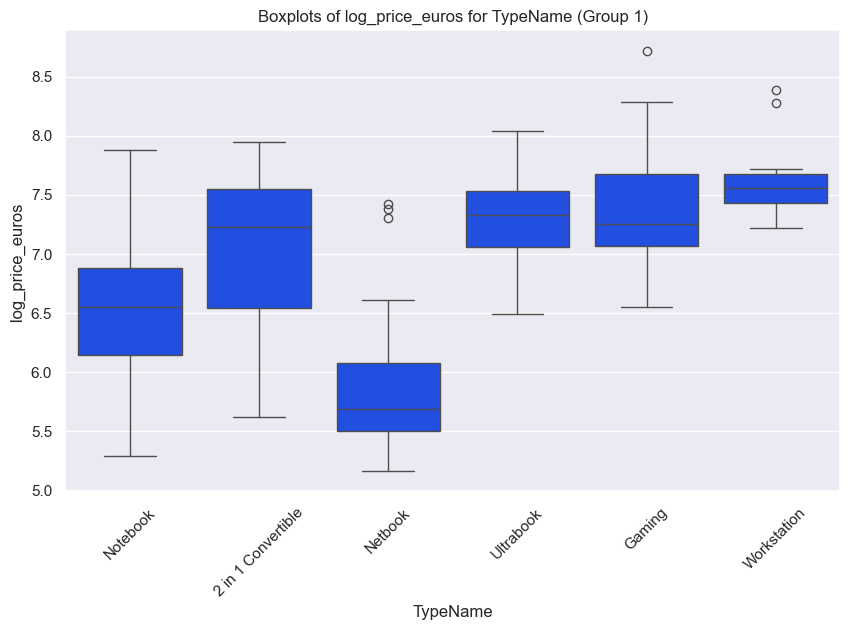

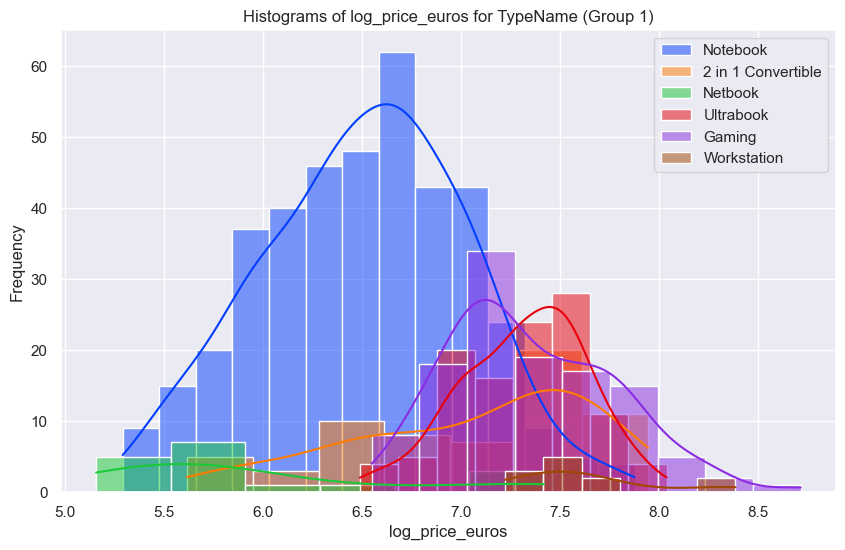

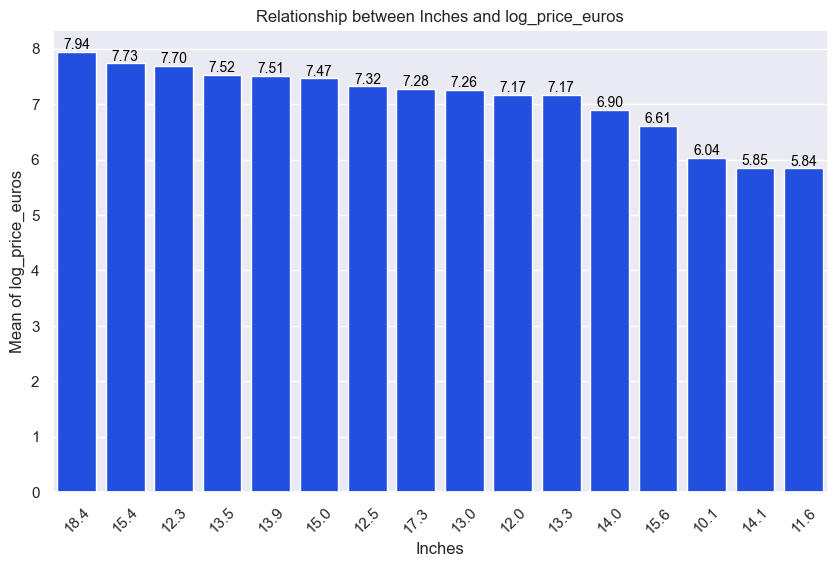

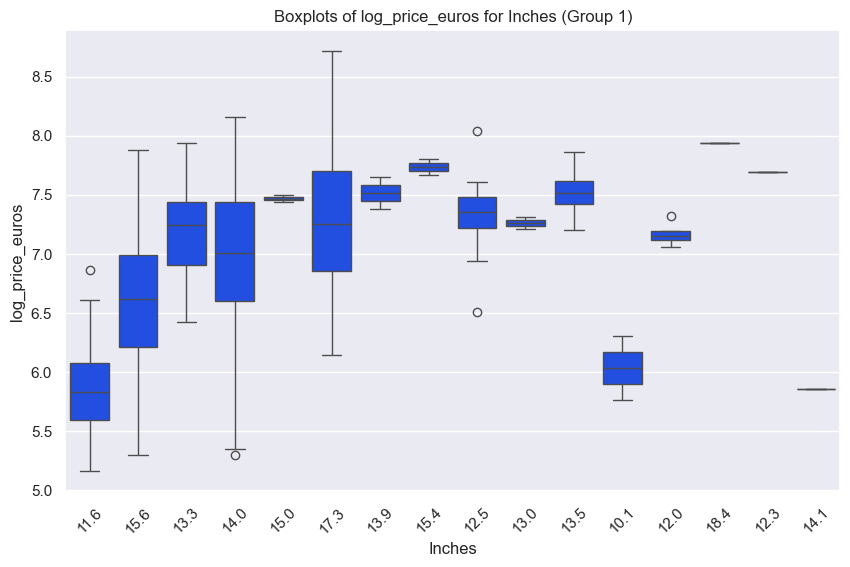

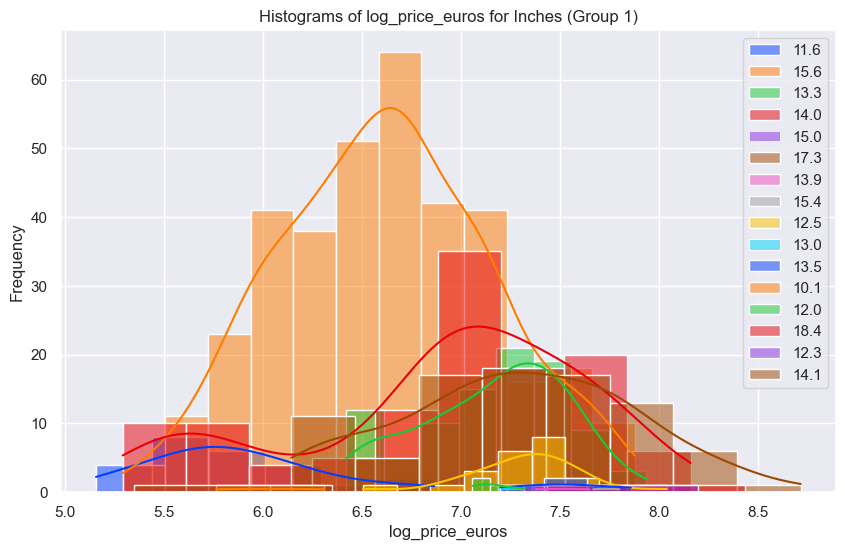

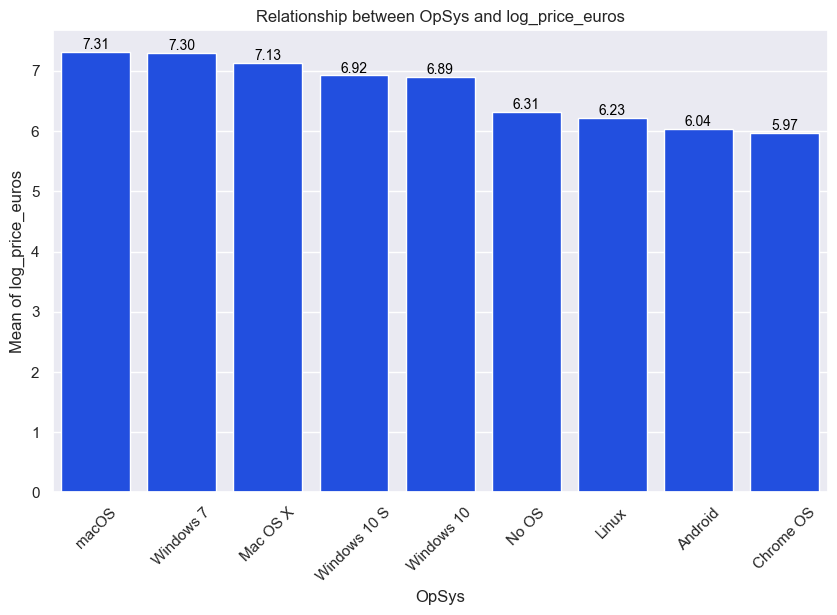

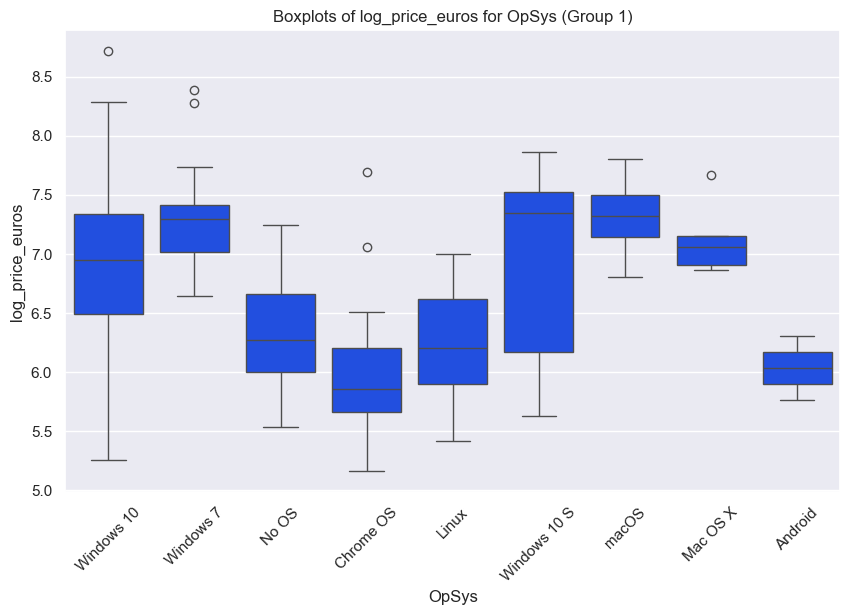

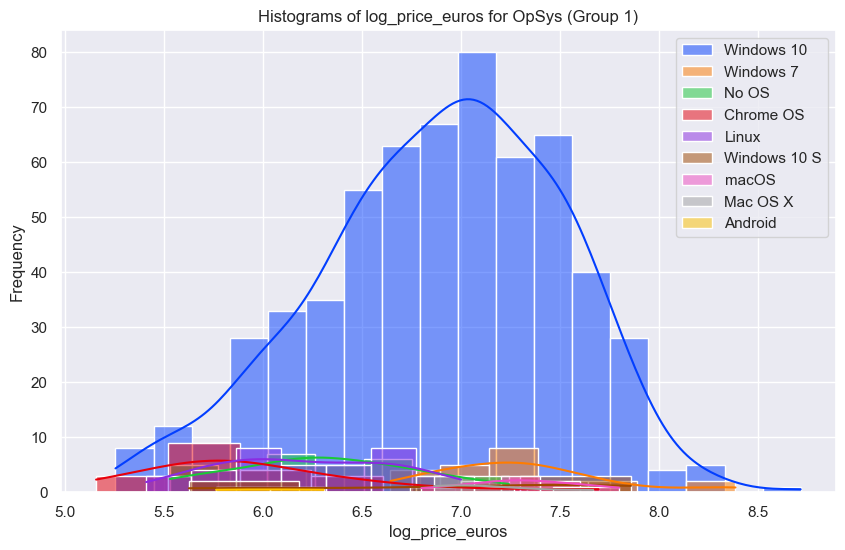

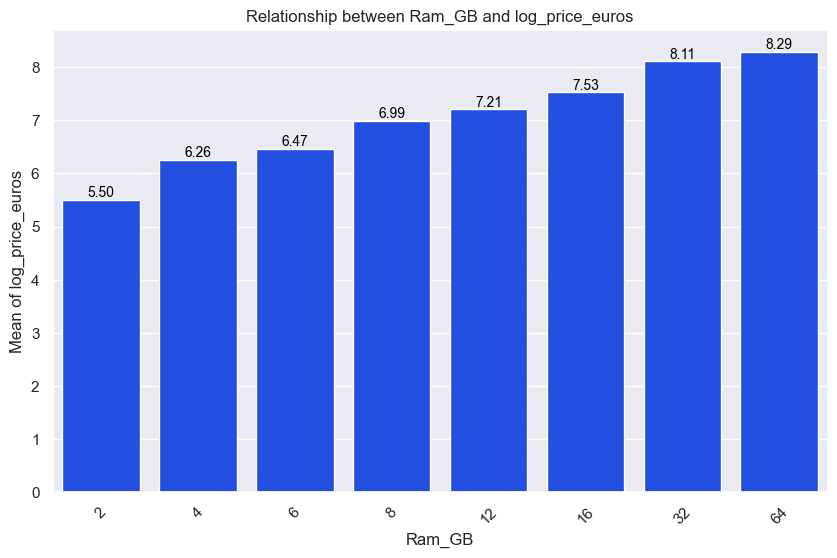

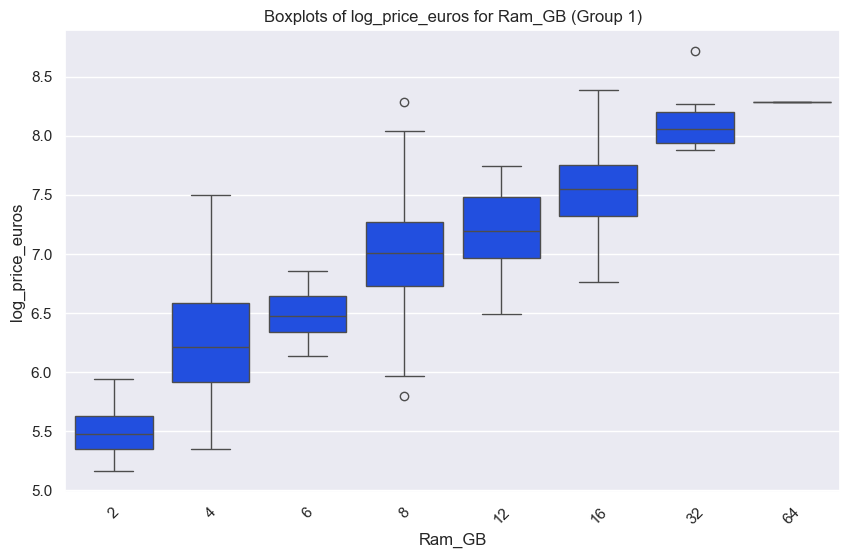

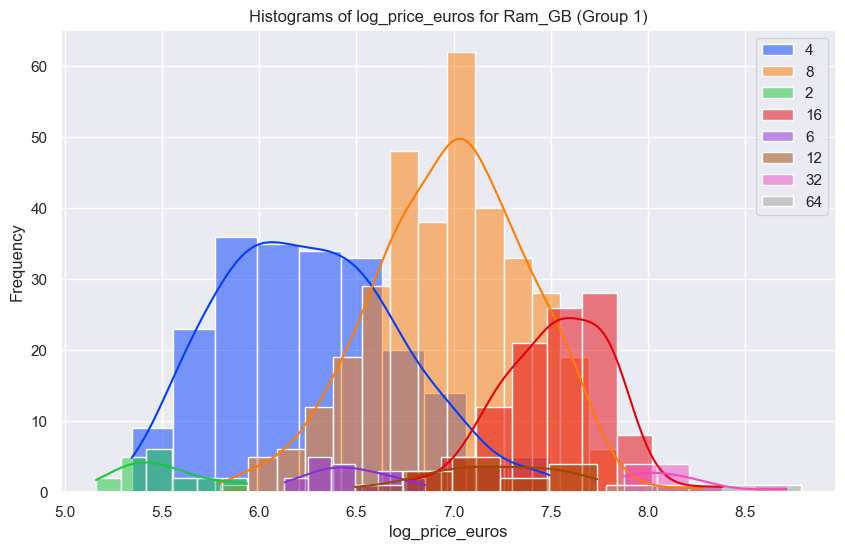

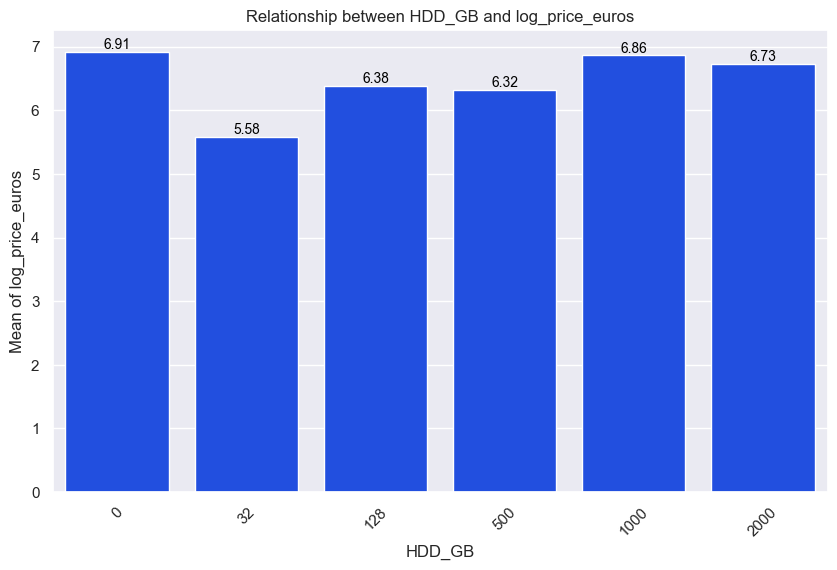

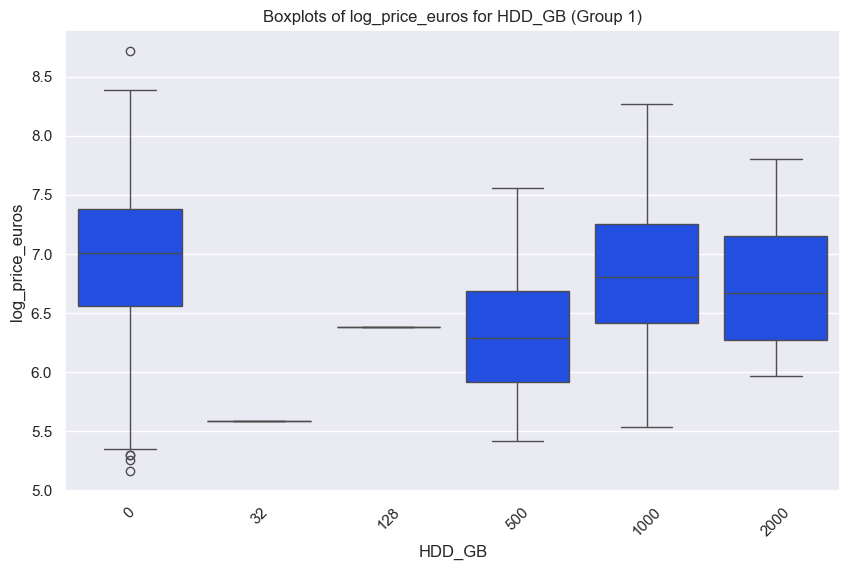

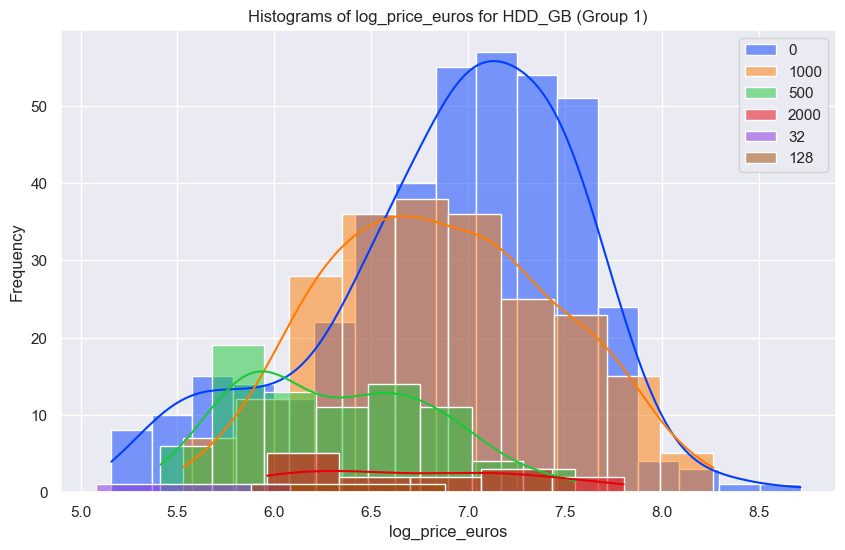

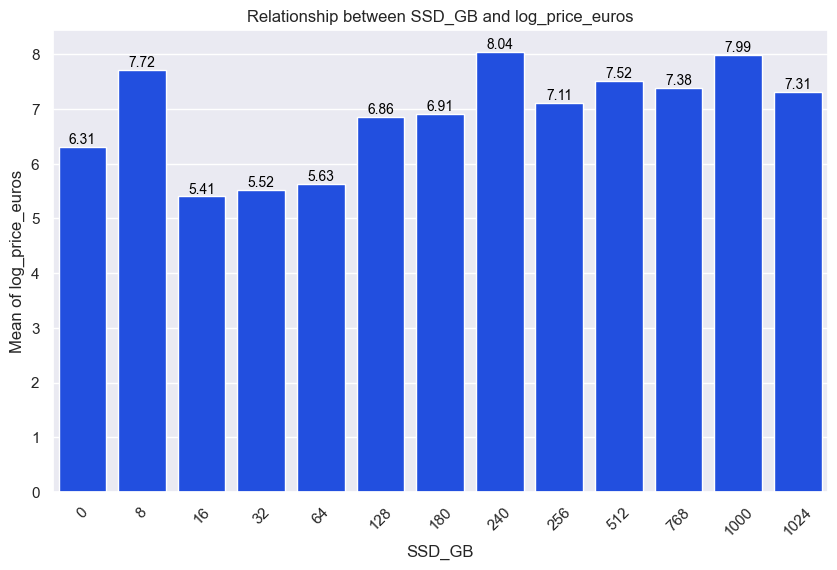

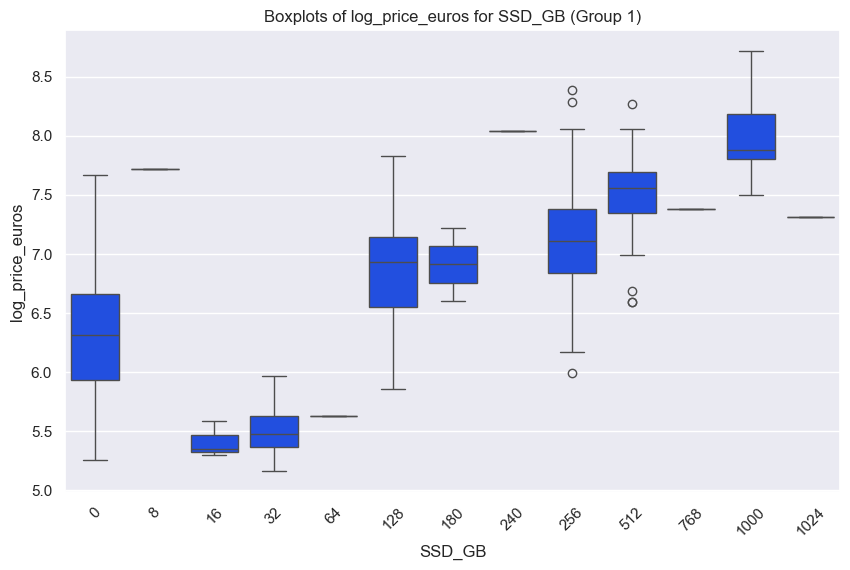

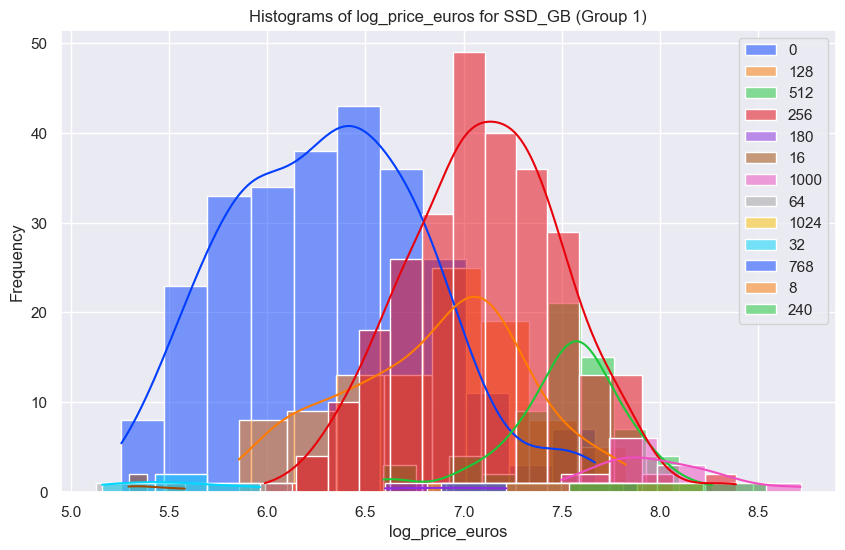

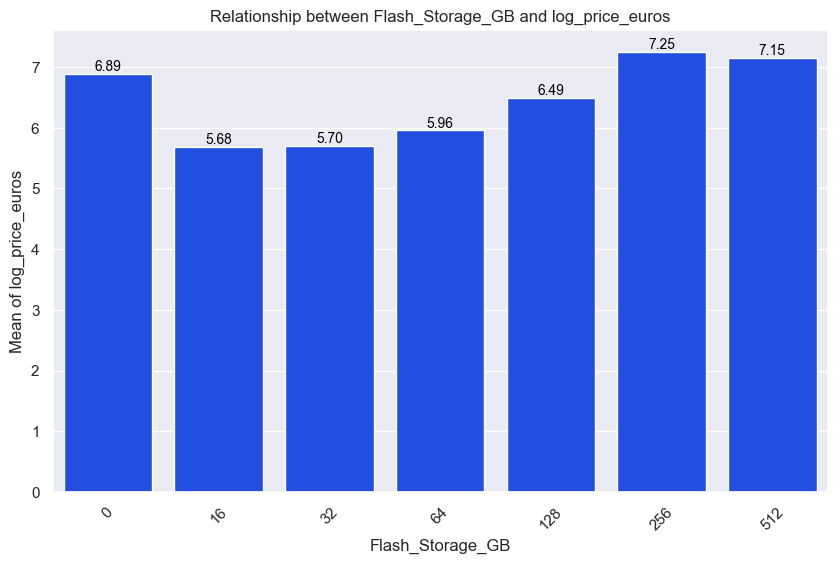

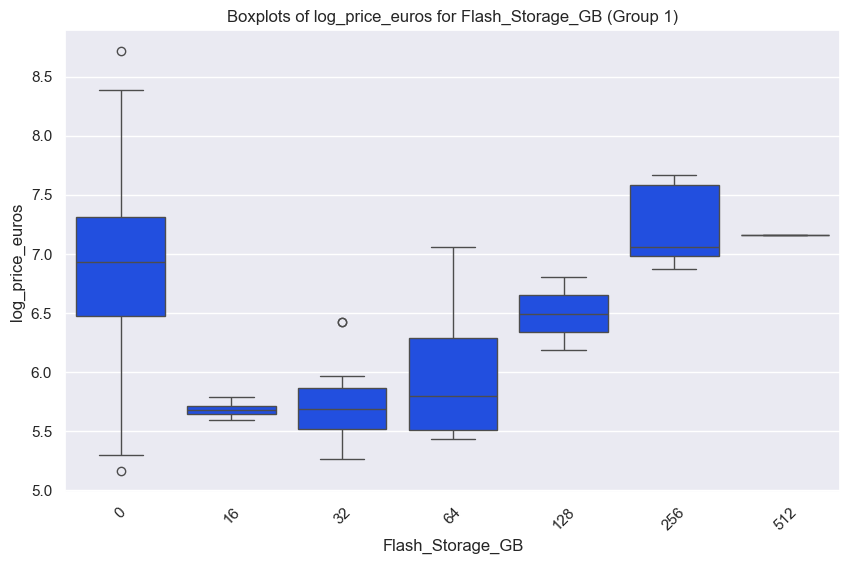

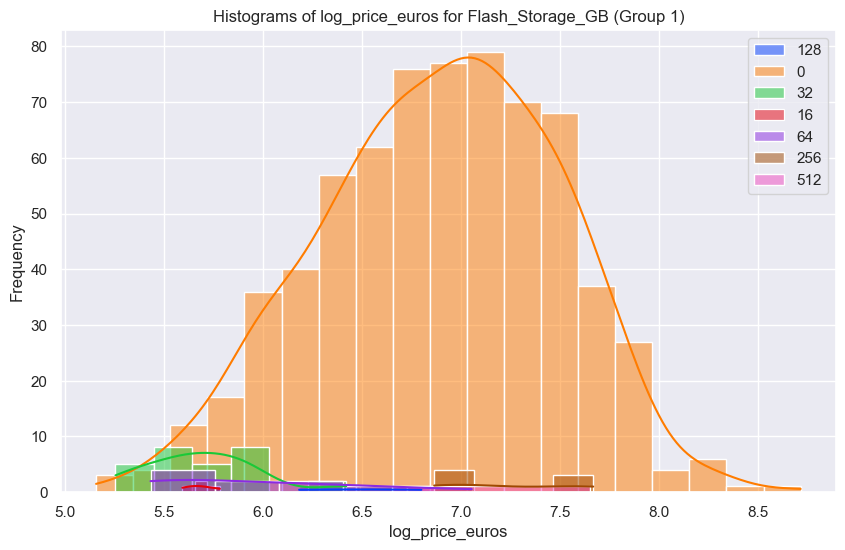

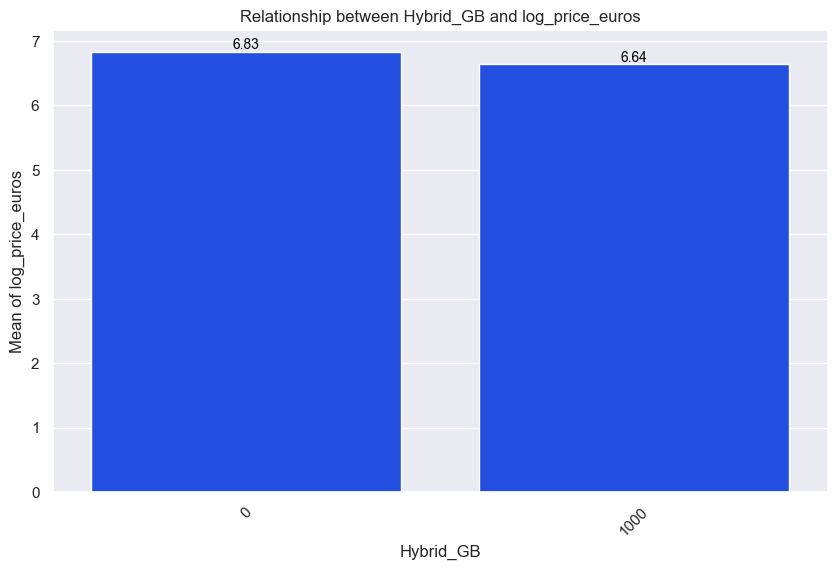

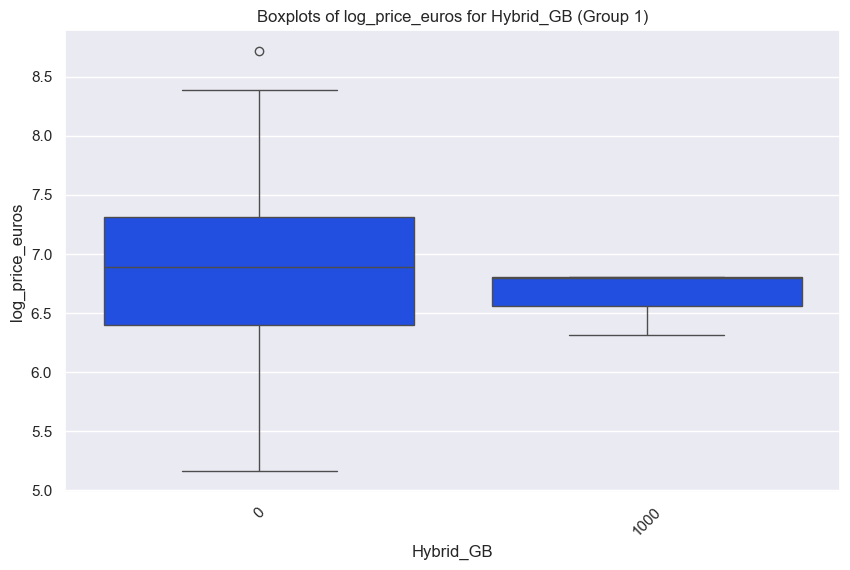

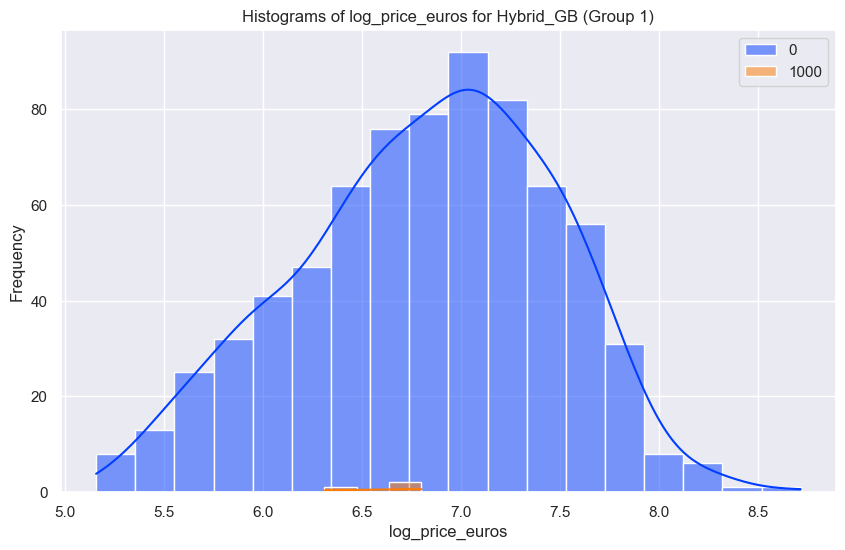

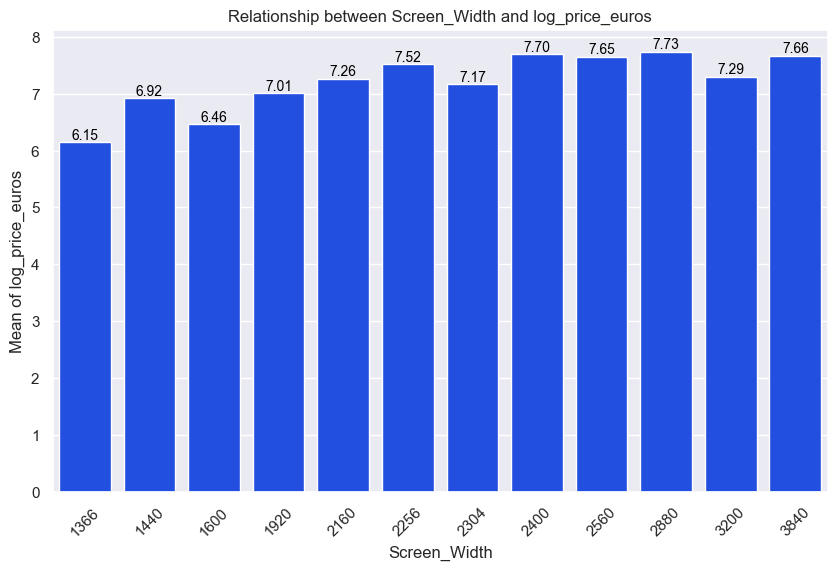

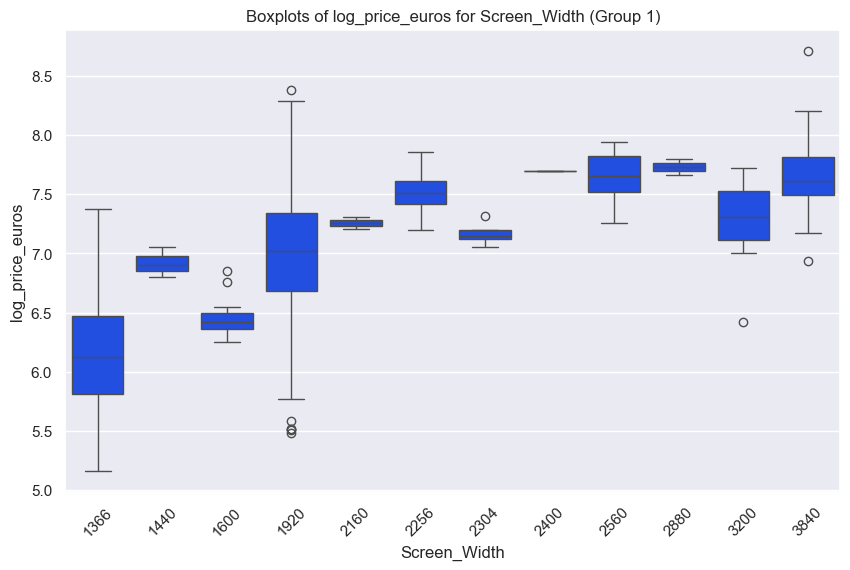

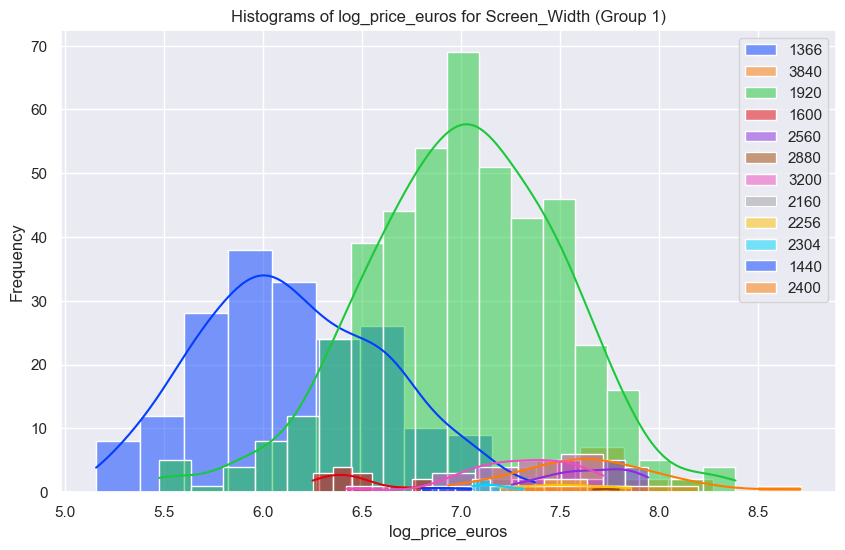

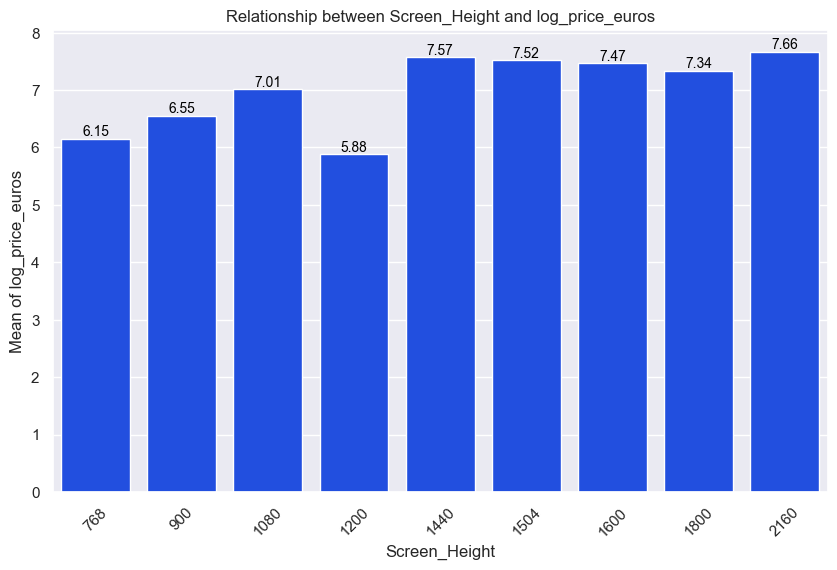

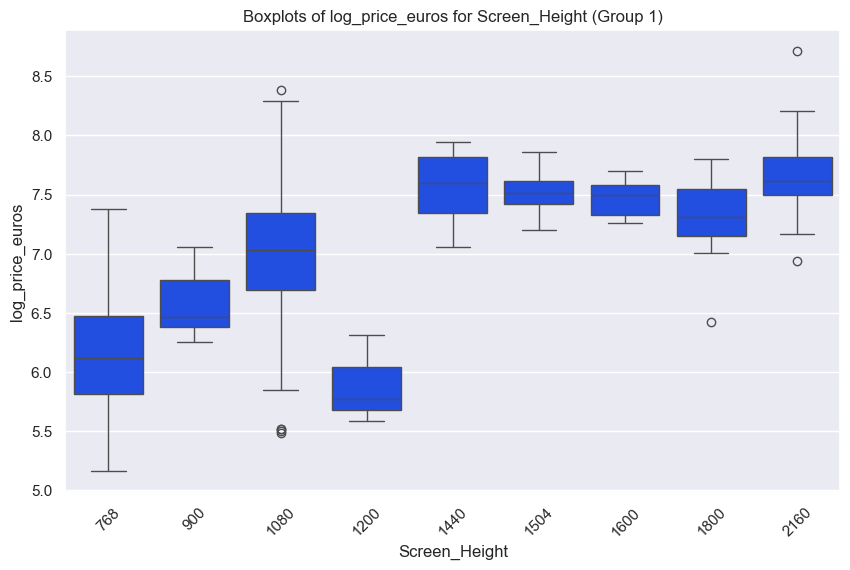

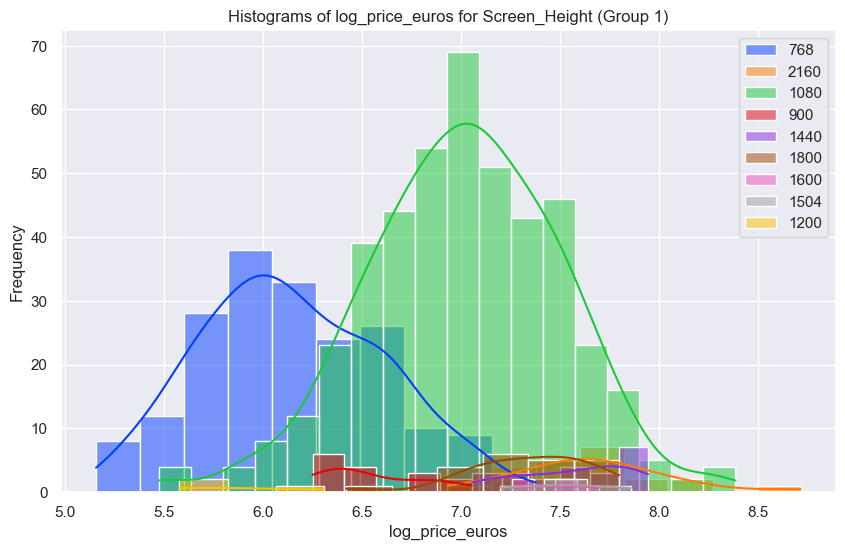

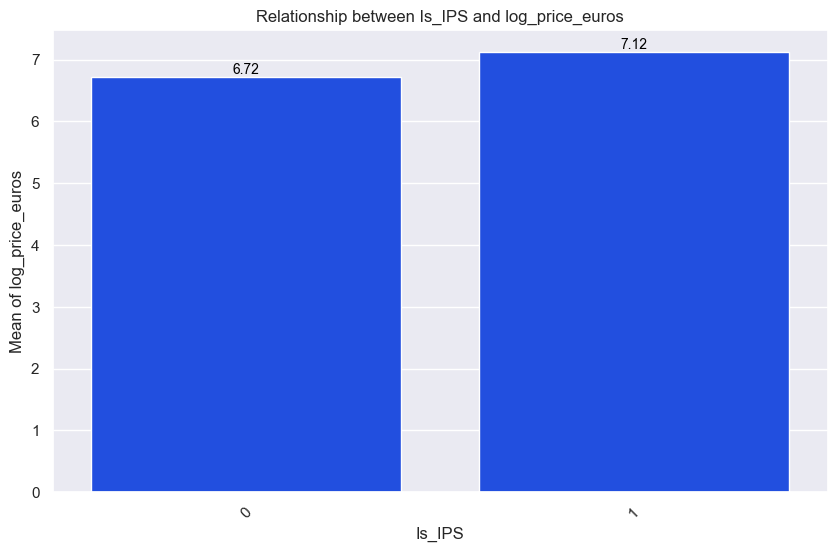

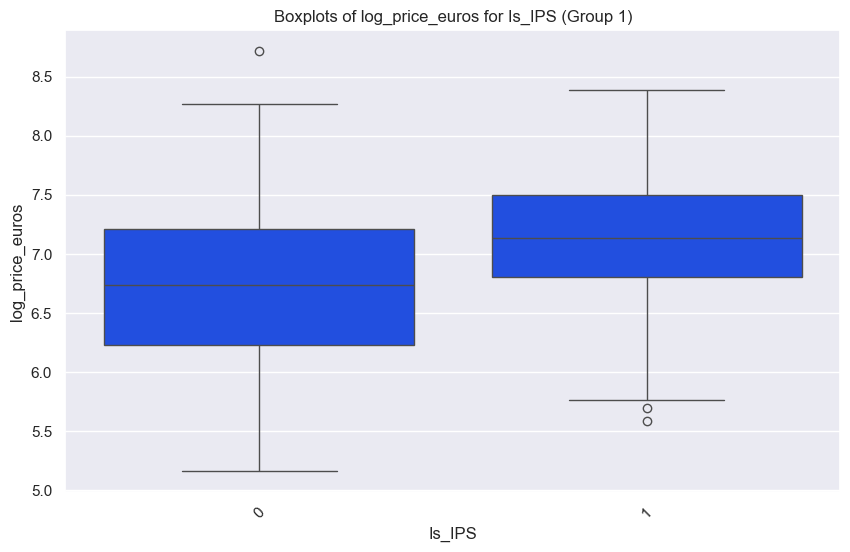

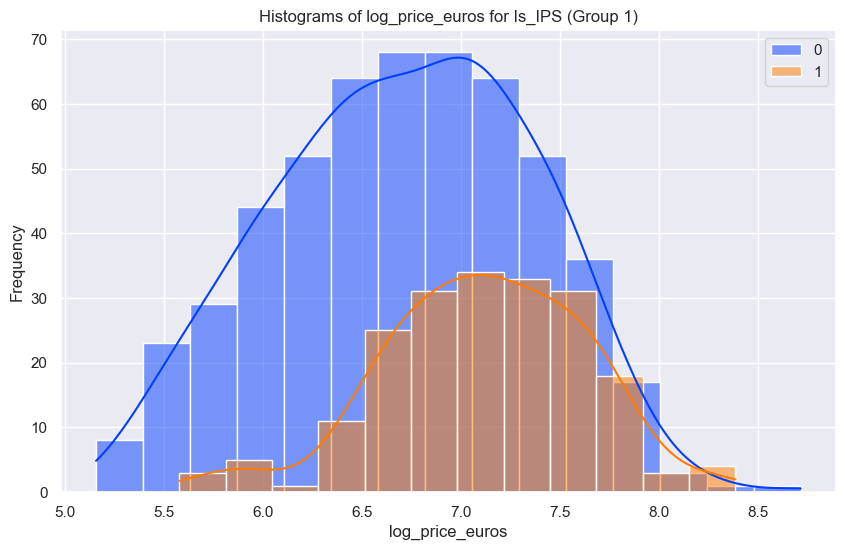

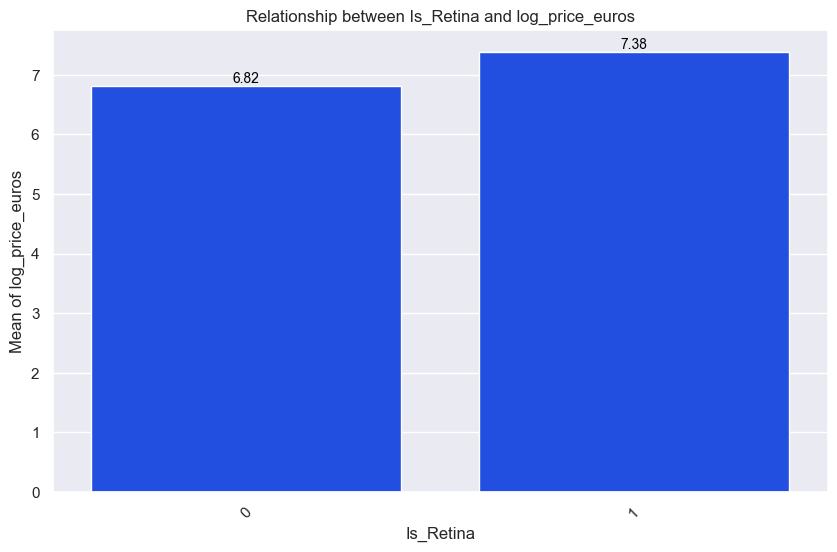

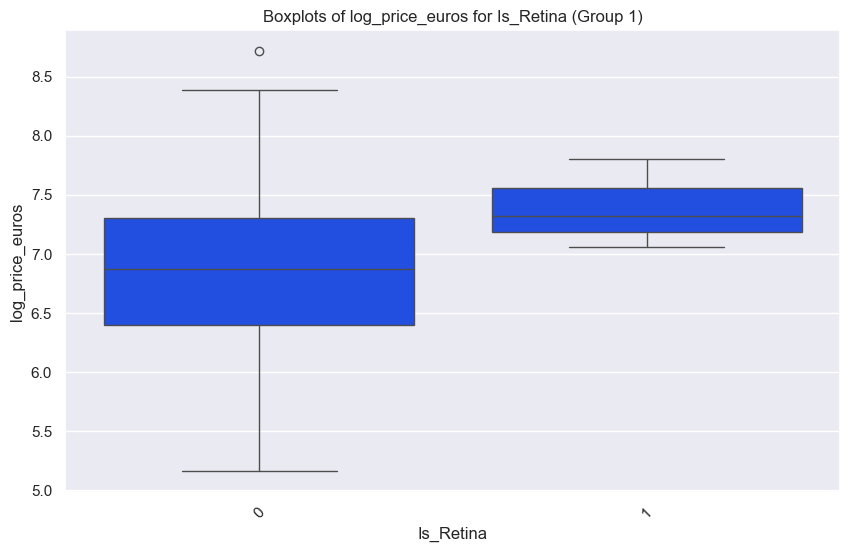

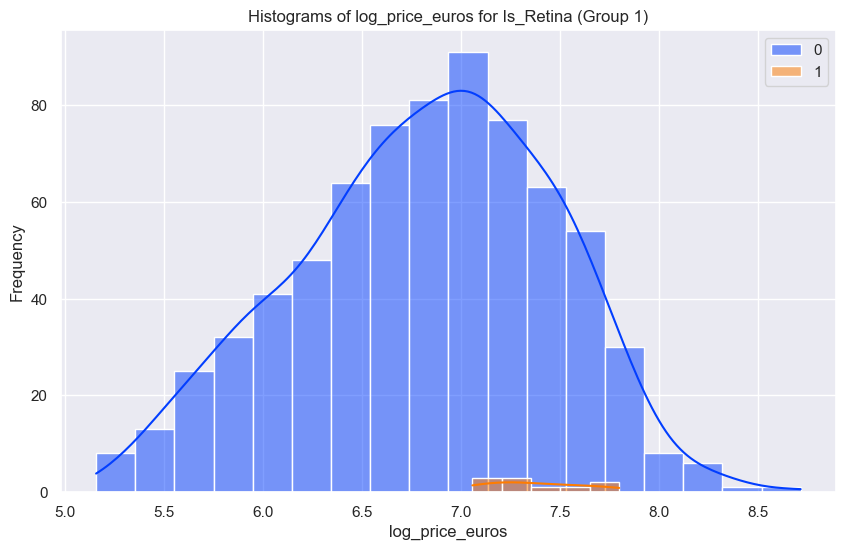

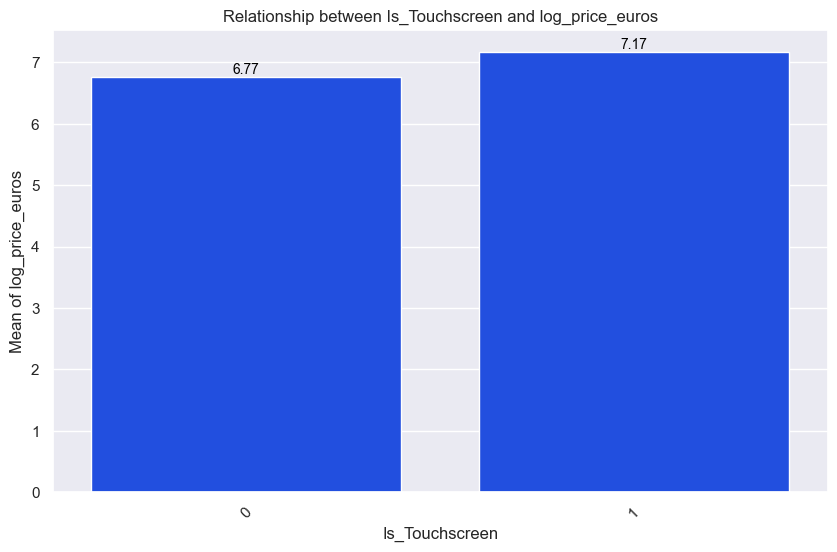

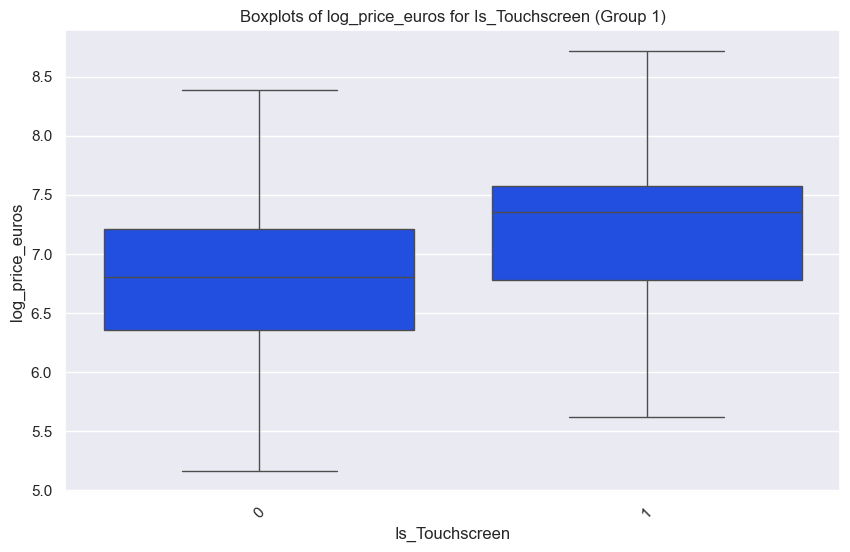

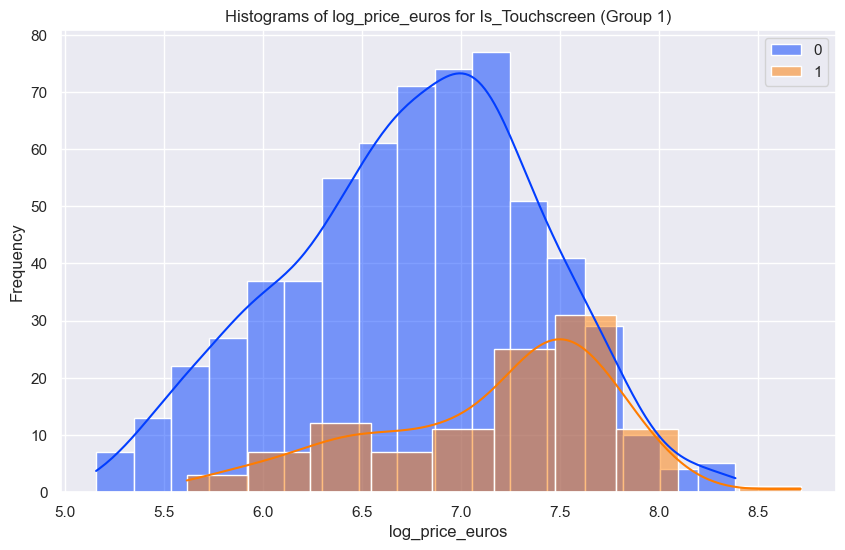

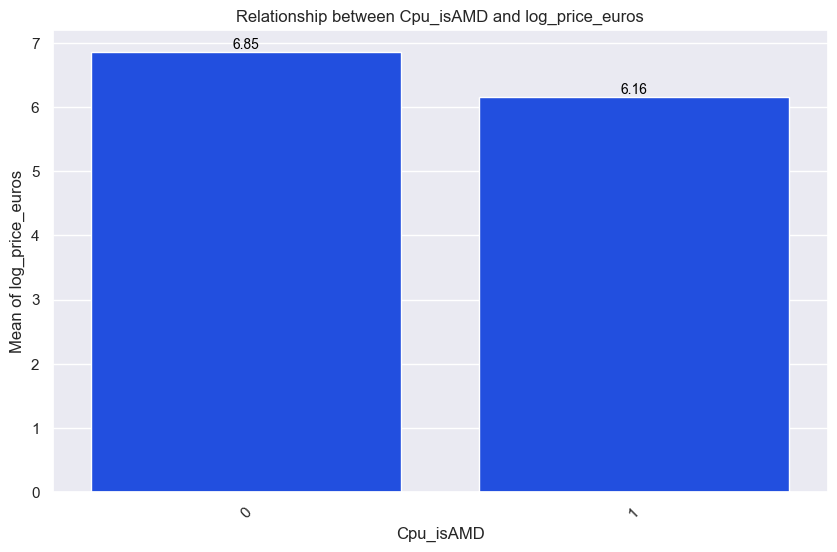

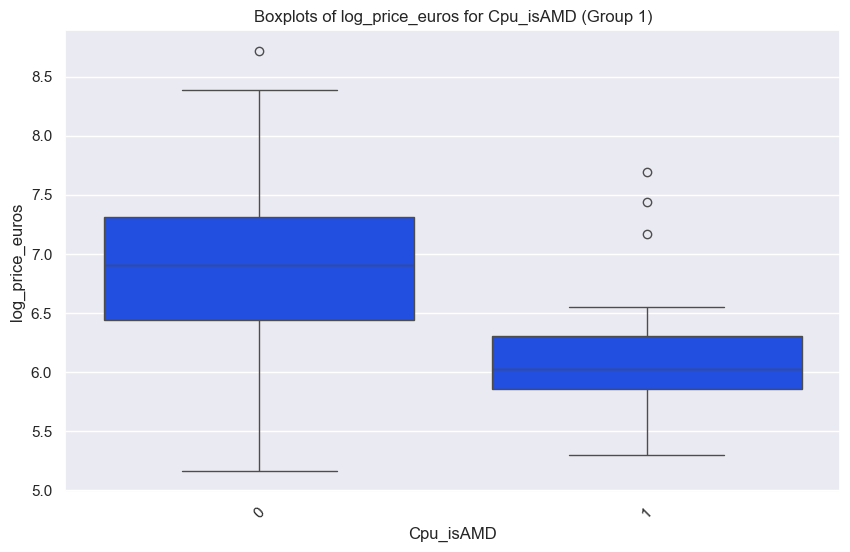

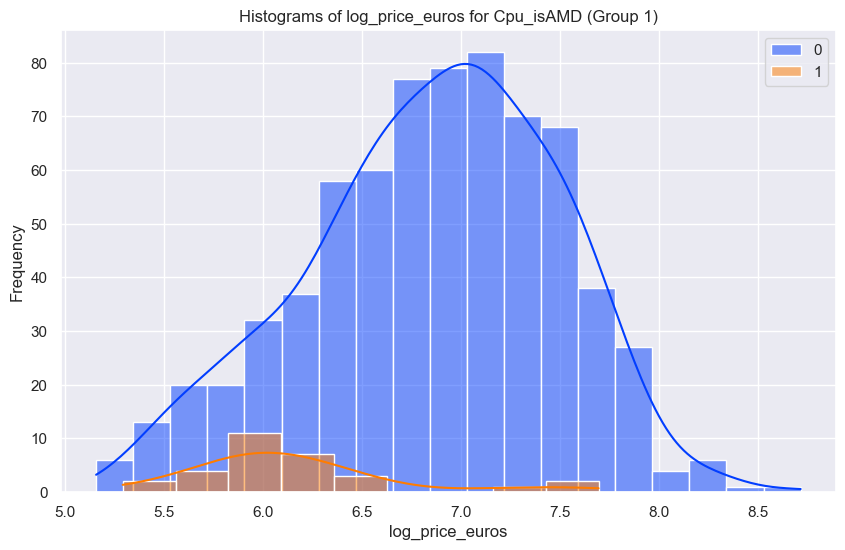

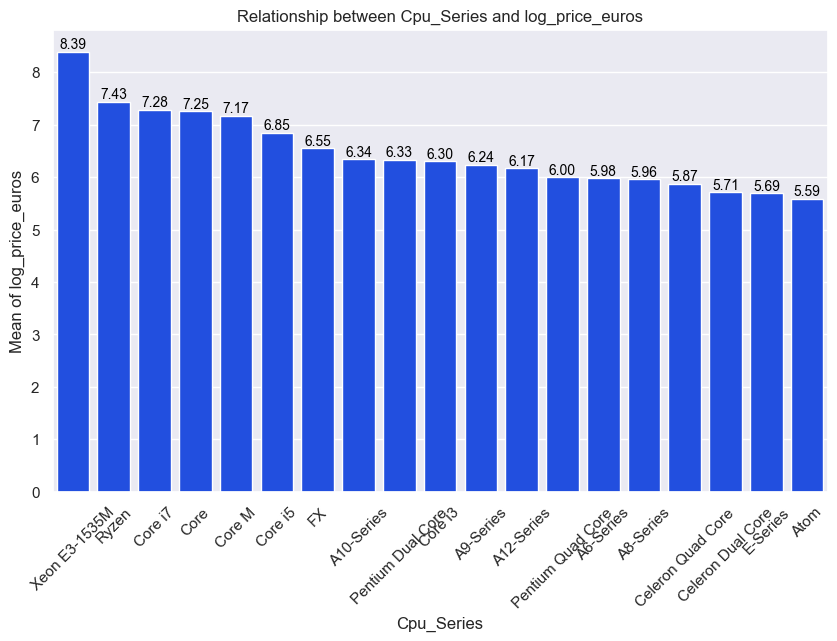

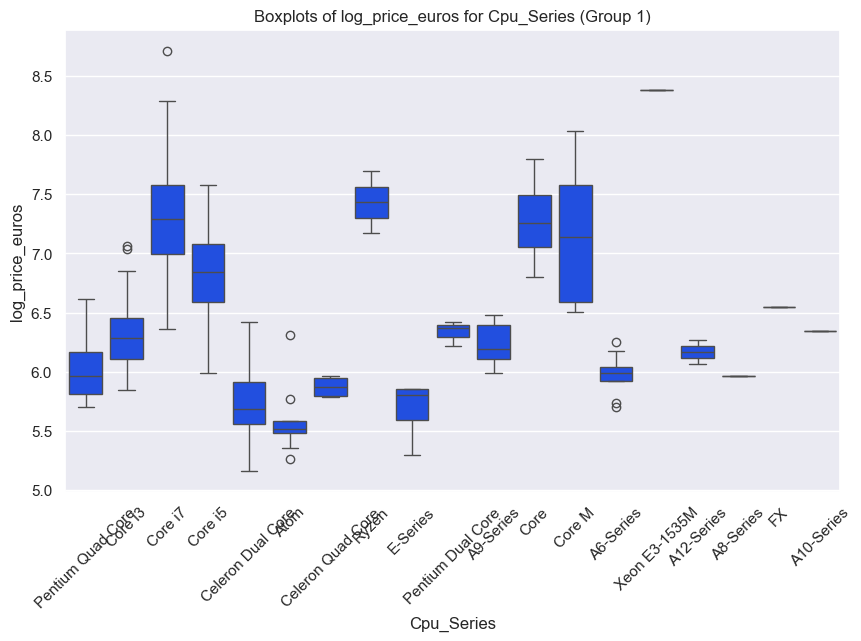

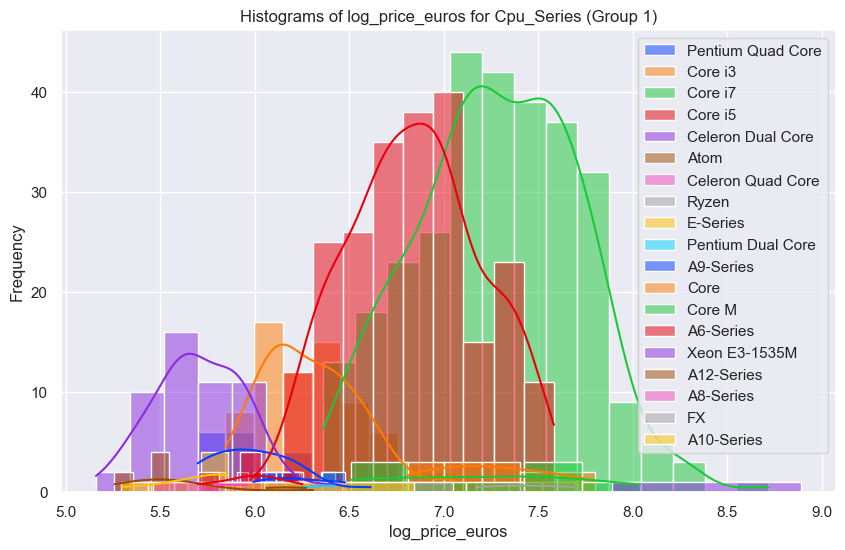

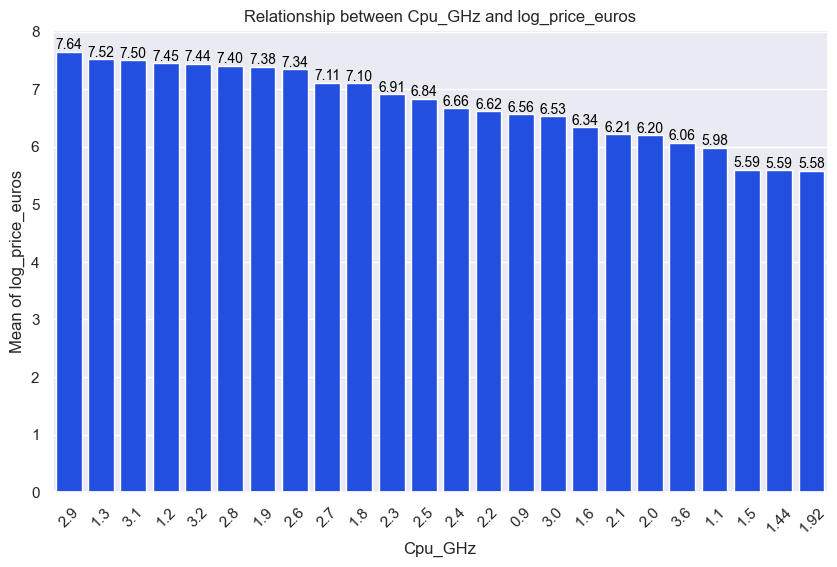

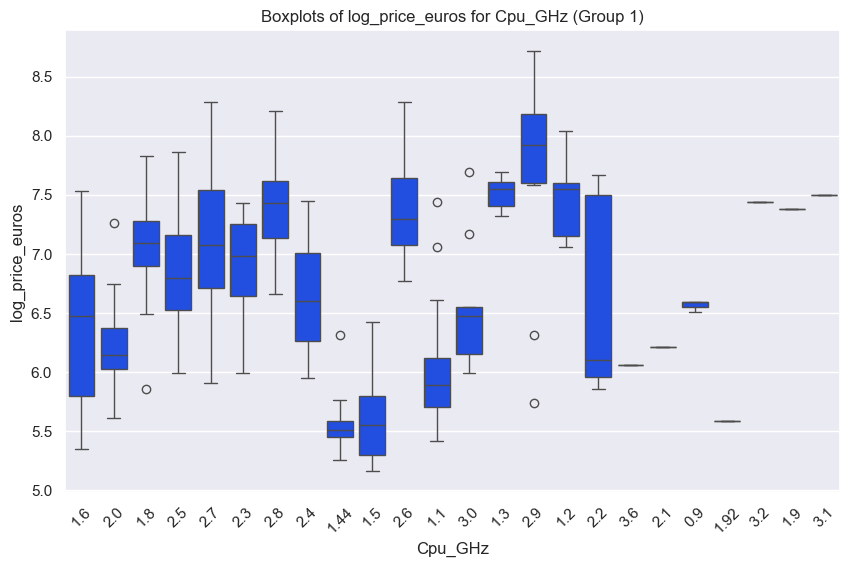

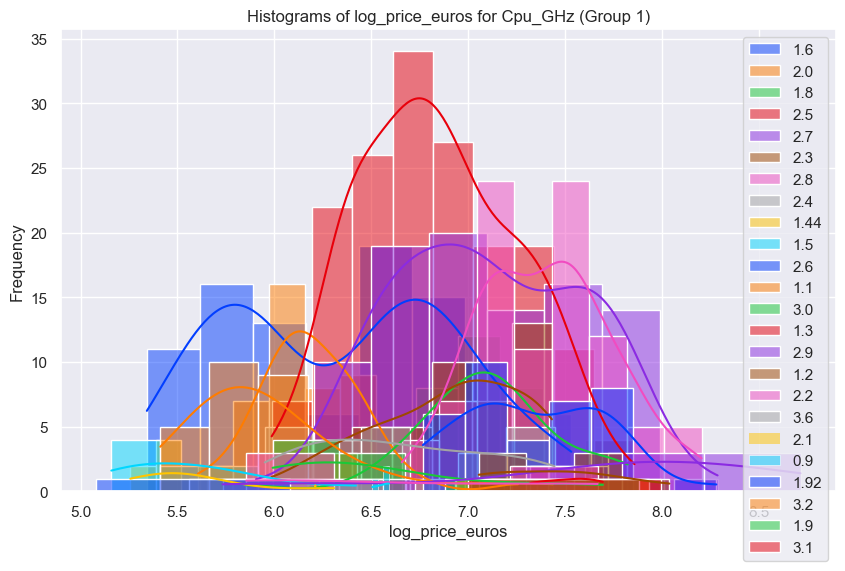

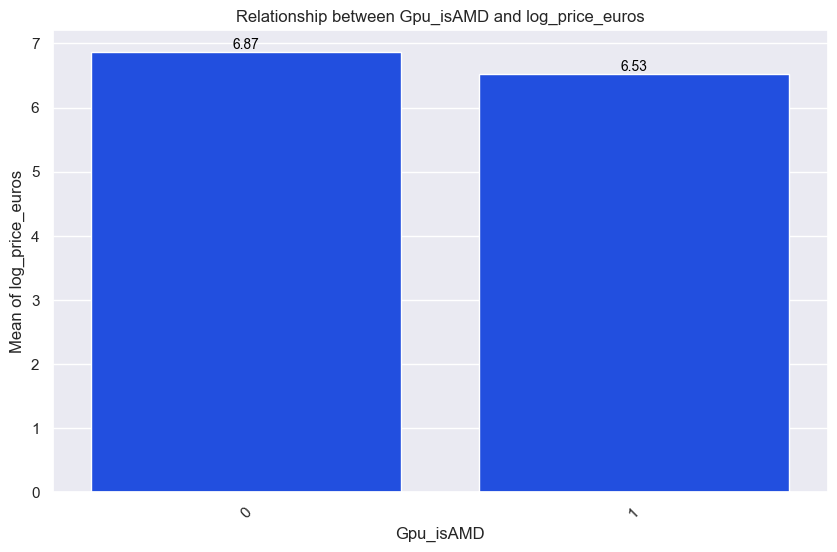

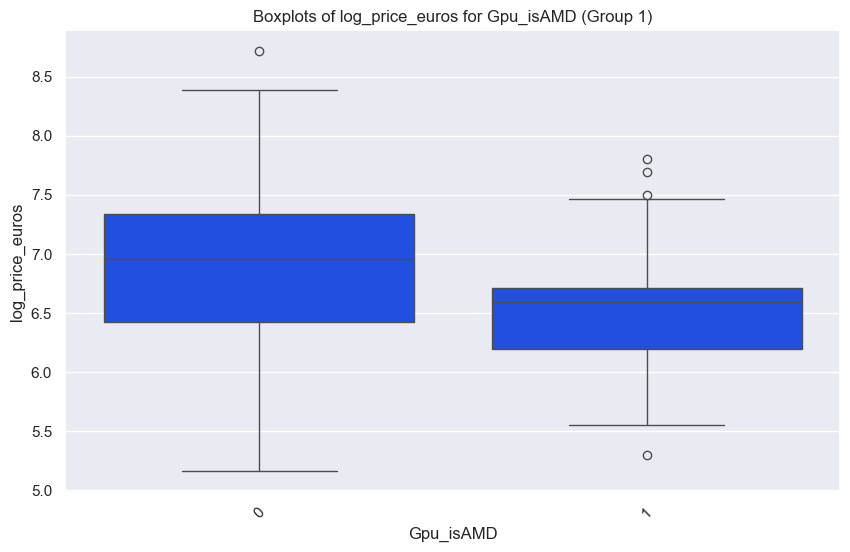

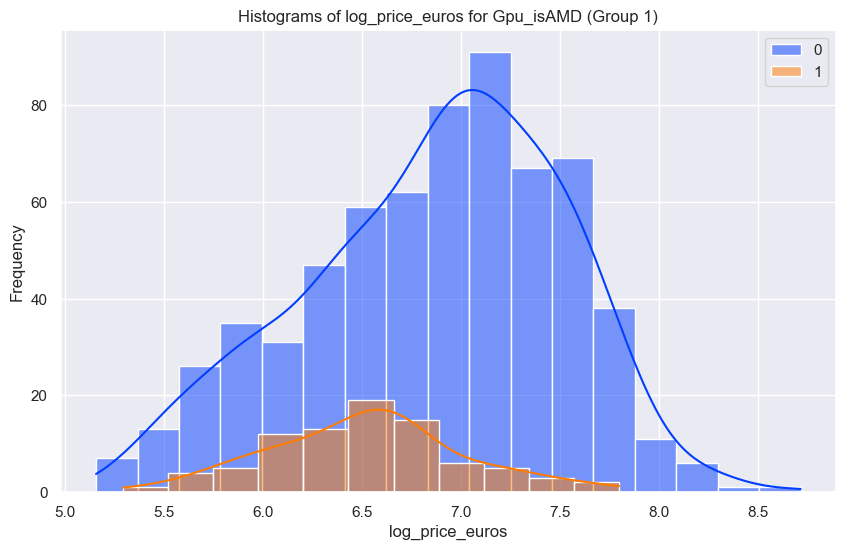

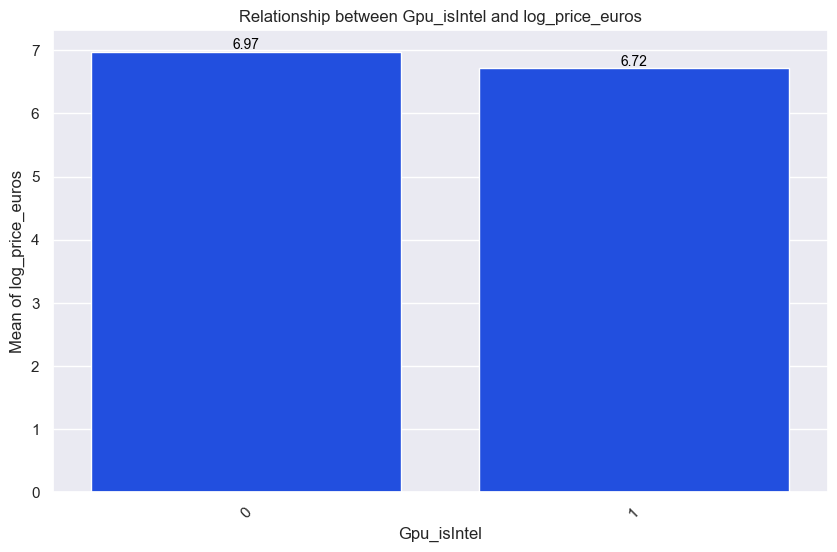

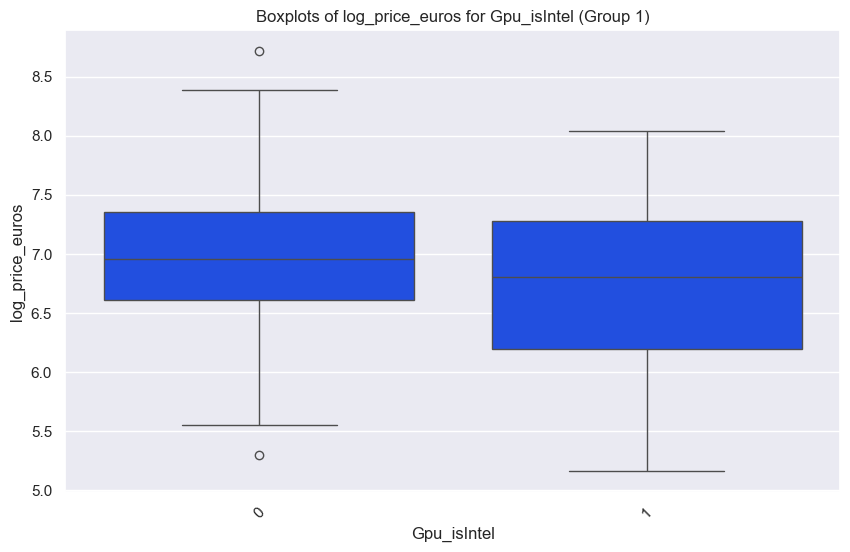

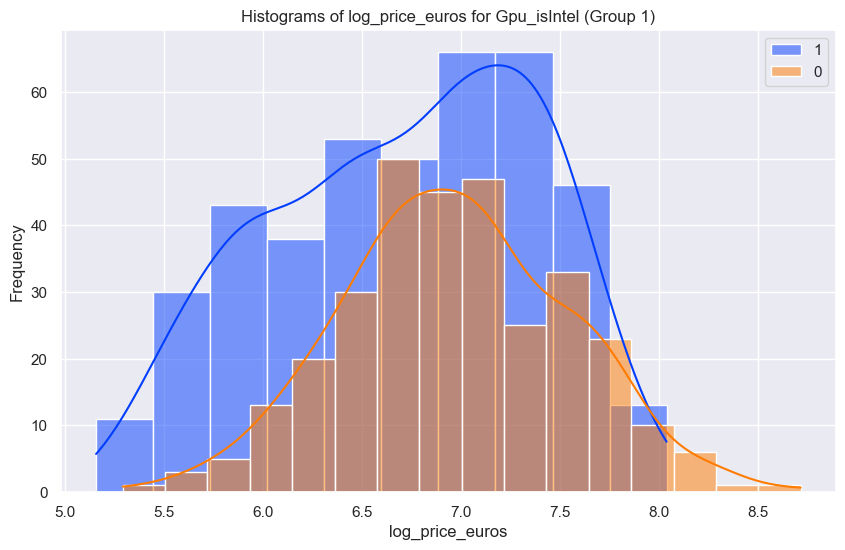

In [33]:
for feature in cat_features:
    if feature not in cat_features_high_card:
        viz.plot_categorical_numerical_relationship(train_set, feature, target, group_size=cat_max_nunique)
        viz.boxplots_grouped(train_set, feature, target, group_size=cat_max_nunique)
        viz.plot_histograms_grouped(train_set, feature, target, group_size=cat_max_nunique)
    

Es algo complicado y lento de analizar visualmente pero hay algunas features que parecen menos interesantes si miramos su relación con el precio:

- Inches
- La capacidad de la memoria es importante pero también está muy relacionada con el tipo de memoria que sea.
- Resolución (Anchura y altura) de la pantalla tampoco importa mucho
- Los GB de la CPU no importan mucho, pero si la serie y modelo
- GPU Nvidia sí es más importante que AMD o Intel.

Lo único que puedo resaltar es que hay algunos valores de outliers, condicionados a la clase a la que pertecen, que también podría eliminar para que mi modelo generalice mejor, pero de nuevo, `aquí no voy a eliminar más outliers`. Puede que en futuros modelos sí lo haga.

Por ejemplo, he visto outliers simbólicos asociados a:
- Ram_GB = 2, 4
- OpSys = Chrome OS
- Inches = 13.3
- Company = Acer
- TypeName = Notebook

Voy a hacer ahora un análisis de correlación con el *target* de las variables representadas numéricamente (que no es lo mismo que decir que las considero numéricas), y de colinealidad, porque puedo sacar nuevas conclusiones.

<Axes: >

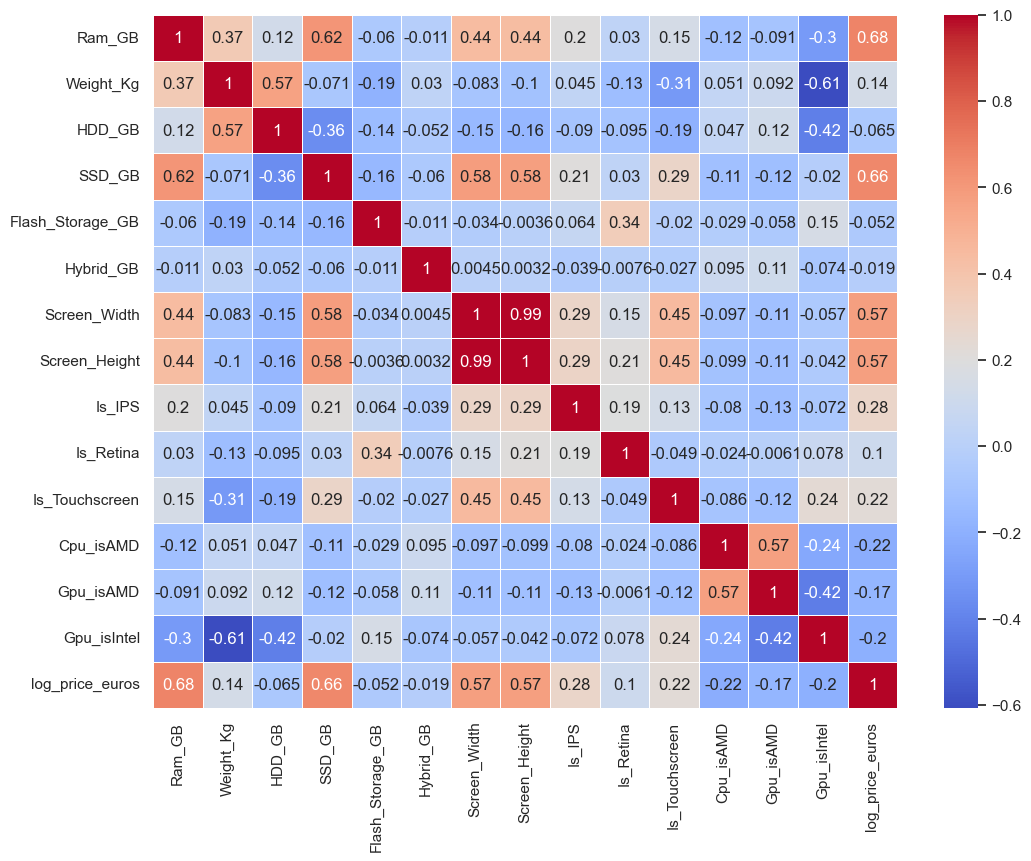

In [34]:
corr_matrix = train_set.drop(columns=['Price_in_euros']).corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)

Conclusiones de esta matriz de correlaciones:

- Igual que habíamos visto en las gráficas, hay varias vartaibles que no parecen tener demasiada correlación (lineal) con el target: Inches, la capacidad del disco duro (pero sí el tiopo), 

- Si trato "Ram_GB" como una numérica discreta, encuentro que tiene una alta correlación con "log_price_euros", y puede que sea más conveniente que tratarla como una categórica.

- "Weight_Kg" e "Inches" que tienen un colinealidad de 0.84 peligrosa.

- Y tengo dos grupos entre los que tendré que elegir (el tipo de memoria y capacidad total, o las columnas que ya incluyen tipo de memoria y capacidad)

Todas las conclusiones que he sacado hasta este punto van a servir para probar diferentes features, tratarlas de diferente forma y probar varios modelos de regresión.

# 5. Split X e y


In [35]:
target

'log_price_euros'

In [36]:
# Directamente sobre el set enhanced
X_train = train_set.drop(columns=[target, 'Price_in_euros'])
X_valid = valid_set.drop(columns=[target, 'Price_in_euros'])

y_train = train_set[target]
y_valid = valid_set[target]


In [37]:
print(num_features)
print(cat_features_high_card)
print(cat_features)

['Weight_Kg']
['Cpu_Model', 'Gpu_Model']
['Company', 'TypeName', 'Inches', 'OpSys', 'Ram_GB', 'HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB', 'Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen', 'Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz', 'Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']


### No transformo las features porque voy a usar catboost.

Voy a usar todas las columnas como categóricas puras, y dejar que catboost las maneje.

In [38]:
ds.get_cardinality(X_train)

pandas.DataFrame shape: (729, 22)


Card     %_Card NaN_Values %_NaN_Values     Type  \
Company            19    2.60631          0          0.0   object   
TypeName            6   0.823045          0          0.0   object   
Inches             16   2.194787          0          0.0   object   
OpSys               9   1.234568          0          0.0   object   
Ram_GB              8   1.097394          0          0.0    int32   
Weight_Kg         149  20.438957          0          0.0  float64   
HDD_GB              6   0.823045          0          0.0    int64   
SSD_GB             13   1.783265          0          0.0    int64   
Flash_Storage_GB    7   0.960219          0          0.0    int64   
Hybrid_GB           2   0.274348          0          0.0    int64   
Screen_Width       12   1.646091          0          0.0    int64   
Screen_Height       9   1.234568          0          0.0    int64   
Is_IPS              2   0.274348          0          0.0    int64   
Is_Retina           2   0.274348          0          0.0    int64   
Is_Touchscreen      2   0.274348          0          0.0    int64   
Cpu_isAMD           2   0.274348          0          0.0    int64   
Cpu_Series         19    2.60631          0          0.0   object   
Cpu_Model          77  10.562414          0          0.0   object   
Cpu_GHz            24   3.292181          0          0.0   object   
Gpu_isAMD           2   0.274348          0          0.0    int64   
Gpu_isIntel         2   0.274348          0          0.0    int64   
Gpu_Model          82  11.248285          0          0.0   object   

                               Class  
Company           Numeric - Discrete  
TypeName                   Categoric  
Inches            Numeric - Discrete  
OpSys                      Categoric  
Ram_GB                     Categoric  
Weight_Kg         Numeric - Discrete  
HDD_GB                     Categoric  
SSD_GB            Numeric - Discrete  
Flash_Storage_GB           Categoric  
Hybrid_GB                     Binary  
Screen_Width      Numeric - Discrete  
Screen_Height              Categoric  
Is_IPS                        Binary  
Is_Retina                     Binary  
Is_Touchscreen                Binary  
Cpu_isAMD                     Binary  
Cpu_Series        Numeric - Discrete  
Cpu_Model         Numeric - Discrete  
Cpu_GHz           Numeric - Discrete  
Gpu_isAMD                     Binary  
Gpu_isIntel                   Binary  
Gpu_Model         Numeric - Discrete

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 324 to 1301
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           729 non-null    object 
 1   TypeName          729 non-null    object 
 2   Inches            729 non-null    object 
 3   OpSys             729 non-null    object 
 4   Ram_GB            729 non-null    int32  
 5   Weight_Kg         729 non-null    float64
 6   HDD_GB            729 non-null    int64  
 7   SSD_GB            729 non-null    int64  
 8   Flash_Storage_GB  729 non-null    int64  
 9   Hybrid_GB         729 non-null    int64  
 10  Screen_Width      729 non-null    int64  
 11  Screen_Height     729 non-null    int64  
 12  Is_IPS            729 non-null    int64  
 13  Is_Retina         729 non-null    int64  
 14  Is_Touchscreen    729 non-null    int64  
 15  Cpu_isAMD         729 non-null    int64  
 16  Cpu_Series        729 non-null    object 
 17 

# 6. Instanciación de CatBoost

In [41]:
# Qué GPU puedo usar para entrenar CatBoost
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [42]:
# Columnas categóricas
cat_features_index = [X_train.columns.get_loc(feature) for feature in cat_features]
print(cat_features_index)

# Instanciar CatBoost
cat_reg = CatBoostRegressor(cat_features=cat_features_index)

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


# 7. Ajuste de hiperparámetros mediante validación cruzada


In [48]:
# Ajustar hiperparámetros con GridSearchCV
kwargs = {
    'scoring': 'neg_root_mean_squared_error', 
    'cv': 10, 
    'verbose': True,
    'n_jobs': -3
}

param_grid = {
    'iterations': [2000, 3000],
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.07, 0.1],
    'l2_leaf_reg': [1, 2, 3, 4],
    'bagging_temperature': [1],
    'colsample_bylevel': [0.9, None]
}

cat_grid = GridSearchCV(estimator=cat_reg, 
                        param_grid=param_grid, 
                        **kwargs)

# Entrenar modelo y estimar tiempo de ajuste de hiperparámetros
start_time = time.time()
cat_grid.fit(X_train, y_train)
end_time = time.time()
print(f'Tiempo de ejecución: {round((end_time-start_time)/60, 1)} minutos')

# Guardar modelos con "pickle"
os.makedirs('../models', exist_ok=True)
with open('../models/cat_grid_laptop.pkl', 'wb') as file:
    pickle.dump(cat_grid, file)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0:	learn: 0.5986335	total: 163ms	remaining: 5m 26s
1:	learn: 0.5600208	total: 185ms	remaining: 3m 4s
2:	learn: 0.5267897	total: 204ms	remaining: 2m 15s
3:	learn: 0.4967008	total: 230ms	remaining: 1m 54s
4:	learn: 0.4729012	total: 255ms	remaining: 1m 41s
5:	learn: 0.4498698	total: 279ms	remaining: 1m 32s
6:	learn: 0.4285661	total: 301ms	remaining: 1m 25s
7:	learn: 0.4093988	total: 322ms	remaining: 1m 20s
8:	learn: 0.3936711	total: 345ms	remaining: 1m 16s
9:	learn: 0.3803645	total: 368ms	remaining: 1m 13s
10:	learn: 0.3678825	total: 390ms	remaining: 1m 10s
11:	learn: 0.3566055	total: 417ms	remaining: 1m 9s
12:	learn: 0.3456134	total: 442ms	remaining: 1m 7s
13:	learn: 0.3365758	total: 465ms	remaining: 1m 5s
14:	learn: 0.3253892	total: 487ms	remaining: 1m 4s
15:	learn: 0.3175612	total: 506ms	remaining: 1m 2s
16:	learn: 0.3113517	total: 530ms	remaining: 1m 1s
17:	learn: 0.3040872	total: 557ms	remaining: 1m 1s
18:	learn: 0.2985195	total: 584ms	remaining: 1m
19:	learn: 0.2923453	total: 618ms	

### Validación de modelo

Mejor modelo: <catboost.core.CatBoostRegressor object at 0x0000022FDC8AC080>
Mejores hiperparámetros: {'bagging_temperature': 1, 'colsample_bylevel': None, 'depth': 5, 'iterations': 2000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Mejor score: 0.19335068196485714
RMSE en el conjunto de train: 185.04086248827096
RMSE en el conjunto de validación: 160.1321845831355


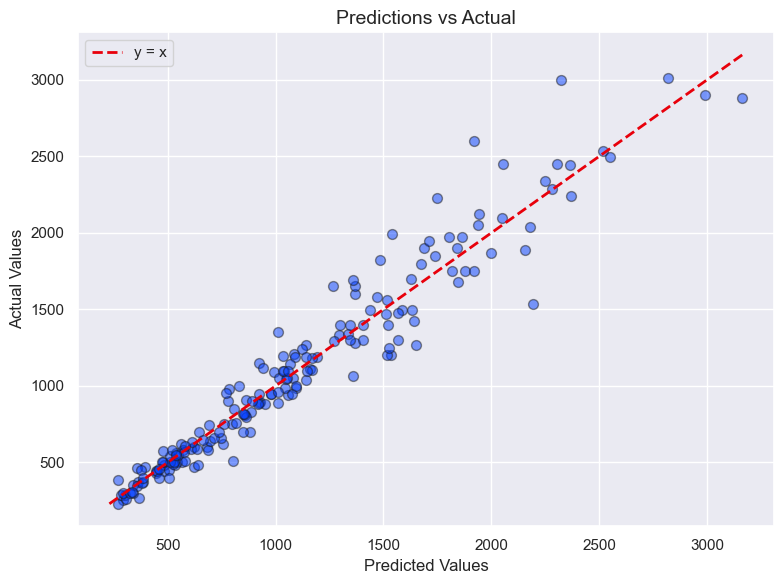

In [43]:
# CatBoost, GridSearchCV, stats

with open('../models/cat_grid_laptop.pkl', 'rb') as file:
    cat_grid = pickle.load(file)

print(f"Mejor modelo: {cat_grid.best_estimator_}")
print(f"Mejores hiperparámetros: {cat_grid.best_params_}")
print(f"Mejor score: {-cat_grid.best_score_}")

# Predecir en el conjunto de train
y_pred_train = cat_grid.best_estimator_.predict(X_train)
rmse = root_mean_squared_error(np.exp(y_train), np.exp(y_pred_train))
print(f"RMSE en el conjunto de train: {rmse}")

# Predecir en el conjunto de validación
y_pred_valid = cat_grid.best_estimator_.predict(X_valid)
rmse = root_mean_squared_error(np.exp(y_valid), np.exp(y_pred_valid))
print(f"RMSE en el conjunto de validación: {rmse}")

ml.plot_predictions_vs_actual(np.exp(y_valid), np.exp(y_pred_valid))

# 8. Predicción sobre set de Kaggle.

En este apartado cargamos el "test.csv" de Kaggle sobre el que se van a hacer las predicciones para competición. Hay que hacerle todas las transformaciones que se han hecho al conjunto de train. Y voy a volver a entrenar el modelo con todo el set de train y ajustar los hiperparámetros.

In [44]:
# Volver a cargar el set para Train y preparar ambos modelos
train_set = pd.read_csv('../data/train.csv', index_col=0)
test_set = pd.read_csv('../data/test.csv', index_col=0)

# Transformar la columna "Weight" a numéricas, y convertir "Inches" en categórica
train_set['Ram_GB'] = train_set['Ram'].str.replace('GB', '').astype(int)
train_set["Weight_Kg"] = train_set['Weight'].str.replace('kg', '').astype(float)
train_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

test_set['Ram_GB'] = test_set['Ram'].str.replace('GB', '').astype(int)
test_set["Weight_Kg"] = test_set['Weight'].str.replace('kg', '').astype(float)
test_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

# Eliminar "Product" por su alta cardinalidad
train_set.drop(columns=['Product'], inplace=True)
test_set.drop(columns=['Product'], inplace=True)

# Extraer más información de ['Memory', 'ScreenResolution', 'Cpu', 'Gpu'] y eliminar las columnas orginales
train_set[['HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = train_set['Memory'].apply(fun.extract_memory_by_type)
train_set[['Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen']] = train_set['ScreenResolution'].apply(fun.extract_screen_features)
train_set[['Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz']] = train_set['Cpu'].apply(fun.extract_cpu_features)
train_set[['Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']] = train_set['Gpu'].apply(fun.extract_gpu_features)
train_set.drop(columns=['Memory', 'ScreenResolution', 'Cpu', 'Gpu'], inplace=True)

test_set[['HDD_GB', 'SSD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = test_set['Memory'].apply(fun.extract_memory_by_type)
test_set[['Screen_Width', 'Screen_Height', 'Is_IPS', 'Is_Retina', 'Is_Touchscreen']] = test_set['ScreenResolution'].apply(fun.extract_screen_features)
test_set[['Cpu_isAMD', 'Cpu_Series', 'Cpu_Model', 'Cpu_GHz']] = test_set['Cpu'].apply(fun.extract_cpu_features)
test_set[['Gpu_isAMD', 'Gpu_isIntel', 'Gpu_Model']] = test_set['Gpu'].apply(fun.extract_gpu_features)
test_set.drop(columns=['Memory', 'ScreenResolution', 'Cpu', 'Gpu'], inplace=True)

# Convertir todas las variables categóricas en enteros o string
train_set[['Inches', 'Cpu_GHz']] = train_set[['Inches', 'Cpu_GHz']].astype(str)
test_set[['Inches', 'Cpu_GHz']] = test_set[['Inches', 'Cpu_GHz']].astype(str)

# Eliminar outliers de ['Price_in_euros'] del train
# upper_limit = 3500
# train_set = train_set[~(train_set['Price_in_euros'] >= upper_limit)]

# Transformación logarítmica del target
target = 'log_price_euros'
train_set[target] = np.log(train_set['Price_in_euros'])
train_set.drop(columns=['Price_in_euros'], inplace=True)

# Split X_train e y_train
X_train = train_set.drop(columns=[target])
y_train = train_set[target]
X_test = test_set.copy()

# Definir variables categóricas y la única numérica
num_features = ['Weight_Kg']
cat_features = [col for col in X_train.columns.to_list() if col not in (num_features + [target])]

In [45]:
ds.get_cardinality(X_train)

pandas.DataFrame shape: (912, 22)


Card     %_Card NaN_Values %_NaN_Values     Type  \
Company            19   2.083333          0          0.0   object   
TypeName            6   0.657895          0          0.0   object   
Inches             17   1.864035          0          0.0   object   
OpSys               9   0.986842          0          0.0   object   
Ram_GB              9   0.986842          0          0.0    int32   
Weight_Kg         158  17.324561          0          0.0  float64   
HDD_GB              6   0.657895          0          0.0    int64   
SSD_GB             13   1.425439          0          0.0    int64   
Flash_Storage_GB    7   0.767544          0          0.0    int64   
Hybrid_GB           3   0.328947          0          0.0    int64   
Screen_Width       12   1.315789          0          0.0    int64   
Screen_Height       9   0.986842          0          0.0    int64   
Is_IPS              2   0.219298          0          0.0    int64   
Is_Retina           2   0.219298          0          0.0    int64   
Is_Touchscreen      2   0.219298          0          0.0    int64   
Cpu_isAMD           2   0.219298          0          0.0    int64   
Cpu_Series         20   2.192982          0          0.0   object   
Cpu_Model          84   9.210526          0          0.0   object   
Cpu_GHz            25   2.741228          0          0.0   object   
Gpu_isAMD           2   0.219298          0          0.0    int64   
Gpu_isIntel         2   0.219298          0          0.0    int64   
Gpu_Model          89   9.758772          0          0.0   object   

                               Class  
Company           Numeric - Discrete  
TypeName                   Categoric  
Inches            Numeric - Discrete  
OpSys                      Categoric  
Ram_GB                     Categoric  
Weight_Kg         Numeric - Discrete  
HDD_GB                     Categoric  
SSD_GB            Numeric - Discrete  
Flash_Storage_GB           Categoric  
Hybrid_GB                  Categoric  
Screen_Width      Numeric - Discrete  
Screen_Height              Categoric  
Is_IPS                        Binary  
Is_Retina                     Binary  
Is_Touchscreen                Binary  
Cpu_isAMD                     Binary  
Cpu_Series        Numeric - Discrete  
Cpu_Model         Numeric - Discrete  
Cpu_GHz           Numeric - Discrete  
Gpu_isAMD                     Binary  
Gpu_isIntel                   Binary  
Gpu_Model         Numeric - Discrete

NO vuelvo a ajustar los hiperparámetros, aunque sí entreno el modelo con todo el set de train

### CatBoost predictions

In [46]:
model = 'cat_grid_laptop.pkl'
subm = 'submission_cat_grid_laptop.csv'

with open(f'../models/{model}', 'rb') as file:
    model = pickle.load(file)

# Mejor modelo 
best_model = model.best_estimator_

# Re-entrenar el mejor modelo con el set completo de entrenamiento
best_model.fit(X_train, y_train)

# Predicción
pred = np.exp(best_model.predict(X_test))

submission = pd.DataFrame({'laptop_ID': X_test.index, 
                           'Price_in_euros': pred})
display(submission.head())

fun.kaggle_checker(submission, path=f'../submissions/{subm}')

0:	learn: 0.5921644	total: 169ms	remaining: 5m 37s
1:	learn: 0.5551938	total: 188ms	remaining: 3m 7s
2:	learn: 0.5210745	total: 206ms	remaining: 2m 16s
3:	learn: 0.4936346	total: 226ms	remaining: 1m 52s
4:	learn: 0.4695075	total: 244ms	remaining: 1m 37s
5:	learn: 0.4476495	total: 262ms	remaining: 1m 27s
6:	learn: 0.4263964	total: 279ms	remaining: 1m 19s
7:	learn: 0.4079505	total: 296ms	remaining: 1m 13s
8:	learn: 0.3916937	total: 313ms	remaining: 1m 9s
9:	learn: 0.3762230	total: 330ms	remaining: 1m 5s
10:	learn: 0.3623130	total: 347ms	remaining: 1m 2s
11:	learn: 0.3505514	total: 365ms	remaining: 1m
12:	learn: 0.3385509	total: 382ms	remaining: 58.4s
13:	learn: 0.3294880	total: 400ms	remaining: 56.7s
14:	learn: 0.3216664	total: 416ms	remaining: 55.1s
15:	learn: 0.3139885	total: 434ms	remaining: 53.8s
16:	learn: 0.3064819	total: 451ms	remaining: 52.6s
17:	learn: 0.3012882	total: 468ms	remaining: 51.5s
18:	learn: 0.2961302	total: 485ms	remaining: 50.6s
19:	learn: 0.2907195	total: 503ms	rem

laptop_ID  Price_in_euros
0        209     1259.621819
1       1281      289.742714
2       1168      345.297705
3       1231      843.349448
4       1020      923.306376

You're ready to submit!


Las etiquetas del set de test no son públicas, pero tras cargar los datos en Kaggle, las predicciones mostraron un RMSE de 253 euros. Este valor de error cuadrático medio raíz (RMSE) refleja la diferencia promedio entre los valores predichos y los valores reales.